# Notebook for Bayesian cooling model for Grenville Compilation

In [1]:
from BACH import *
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as T
from theano.compile.ops import as_op
import arviz as az
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%config InlineBackend.figure_format='retina'

In [2]:
closure_temp_bounds_dict = {'Biotite':[350, 70/2], 
                            'Muscovite':[490, 90/2],
                            'Hornblende':[500, 50/2], 
                            'Rutile':[600, 100/2], 
                            'Monazite':[1000,100/2], 
                            'Titanite':[650, 50/2],
                            'Zircon': [950, 50/2],
                            'K-Feldspar':[220, 40/2], 
                            'Phlogopite':[300, 50/2], 
                            'Plagioclase':[250, 50/2]}

color_dict = {'Biotite':'C0', 
              'Muscovite':'C1',
              'Hornblende':'C2', 
              'Rutile':'C3', 
              'Monazite':'C4', 
              'Titanite':'C5', 
              'Zircon':'C6', 
              'K-Feldspar': 'C7', 
              'Phlogopite':'C8',
              'Plagioclase': 'C9'}

In [3]:
def find_x_given_y(xs, ys, y):
    # we assume the points are sorted from max to min!
    if y > max(ys):
        i = np.argmax(ys)
        a1 = xs[i]
        a2 = xs[i-1]
        b1 = ys[i]
        b2 = ys[i-1]
        k = (b1-b2)/(a1-a2)
        
        c = b1-a1*k
        if k == 0:
            return None
        else:
            return (y-c)/k
    
    elif y < min(ys):
        i = np.argmin(ys)-1
        a1 = xs[i]
        a2 = xs[i+1]
        b1 = ys[i]
        b2 = ys[i+1]
        k = (b1-b2)/(a1-a2)
        c = b1-a1*k
        if k == 0:
            return None
        else:
            return (y-c)/k

    else:
        a1 = a2 = 0
        b =  b2 = 0
        k = c = 0
        for i in range(len(ys)-1):
            if ys[i] >= y and ys[i+1] <=y:
                a1 = xs[i]
                a2 = xs[i+1]
                b1 = ys[i]
                b2 = ys[i+1]
                k = (b1-b2)/(a1-a2)
                c = b1-a1*k
                break
        if k == 0:
            return None
        else:
            return (y-c)/k      
        
def find_age_at_temp(df, observed_ages, temp, n_rates, include_start=False):
    age_at_temp = []
    for j in range(df.shape[0]):
        this_row = df.iloc[j]
        this_start_age = this_row['start_age']
        this_start_temp = this_row['start_temp']
        
        this_temp_segments = np.zeros(shape=len(observed_ages))
        for i in range(len(observed_ages)):
            if n_rates==1:
                this_rate = this_row['rate_1']
                this_temp_segments[i] = get_cooling_history_1(this_start_age, this_start_temp, 
                                      this_rate, observed_ages[i])
            if n_rates==2:
                this_rate_1 = this_row['rate_1']
                this_rate_2 = this_row['rate_2']
                
                this_temp_segments[i] = get_cooling_history_2(this_start_age, this_start_temp, 
                                      this_rate_1, this_rate_2, 
                                      this_row['changepoint_1'], this_row['changepoint_2'], observed_ages[i])
            if n_rates==3:
                this_rate_1 = this_row['rate_1']
                this_rate_2 = this_row['rate_2']
                this_rate_3 = this_row['rate_3']
                
                this_temp_segments[i] = get_cooling_history_3(this_start_age, this_start_temp, 
                                      this_rate_1, this_rate_2, this_rate_3,
                                      this_row['changepoint_1'], this_row['changepoint_2'], this_row['changepoint_3'], observed_ages[i])
        if include_start:
            age_at_temp.append( find_x_given_y([this_start_age]+observed_ages, [this_start_temp]+this_temp_segments, temp))
        else:
            
            age_at_temp.append( find_x_given_y(observed_ages, this_temp_segments, temp))
#             print(this_temp_segments)
    return age_at_temp

In [4]:
# function to read trace files, pm.load_trace no longer works!
# need to navigate to the npz file
def load_trace(path):
    data = np.load(path)
    return pd.DataFrame.from_dict({item: data[item] for item in data.files})

## Anchor thermochron 1: Haliburton intrusions of the Bancroft terrane of CMB

In [5]:
Haliburton_ages = pd.read_csv('../data/thermochron_compilation/Bancroft_ages.csv')
Haliburton_ages = Haliburton_ages.sort_values(by='Age', ascending=0).reset_index(drop=1)
Haliburton_ages['closure_temp'] = [closure_temp_bounds_dict[i][0] for i in Haliburton_ages['Age_Material']]
Haliburton_ages['closure_temp_sigma'] = [closure_temp_bounds_dict[i][1] for i in Haliburton_ages['Age_Material']]
# Haliburton_ages

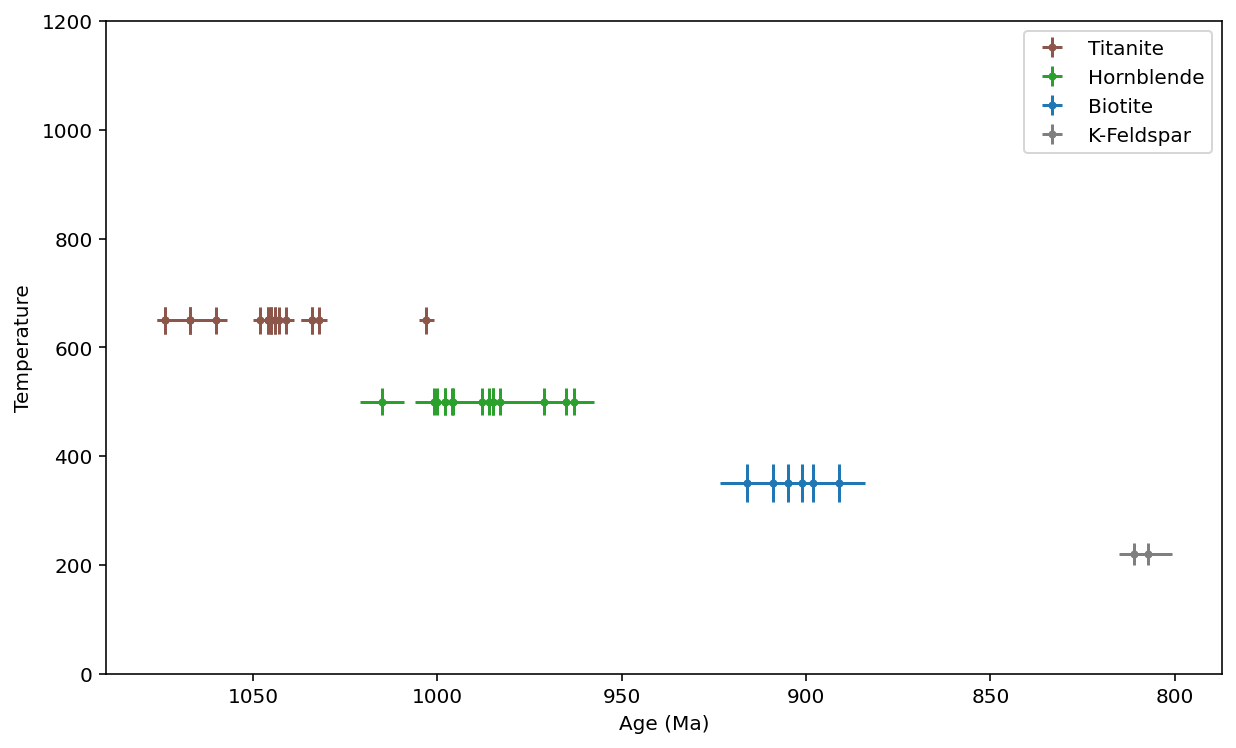

In [6]:
plt.figure(figsize=(10, 6))
for i in Haliburton_ages.Age_Material.unique():
    this_material = Haliburton_ages[Haliburton_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)
plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
plt.ylim(0, 1200)
# plt.xlim(1100, 750)
plt.legend()
plt.show()

In [7]:
Haliburton_nominal_ages = Haliburton_ages['Age'].tolist()
Haliburton_sigmas = list((Haliburton_ages['Error_Minus']+Haliburton_ages['Error_Plus']).to_numpy()/2)
Haliburton_temps = Haliburton_ages['closure_temp']
Haliburton_temp_sigmas = Haliburton_ages['closure_temp_sigma']

In [19]:
with pm.Model() as model:
    
    start_index = np.argmax(Haliburton_nominal_ages)
    start_age = pm.Normal('start_age', Haliburton_nominal_ages[start_index], Haliburton_sigmas[start_index])
    start_temp = pm.Normal('start_temp', Haliburton_temps[start_index], Haliburton_temp_sigmas[start_index])
    print('start age: ', Haliburton_nominal_ages[start_index], 'start temp: ', Haliburton_temps[start_index])
    rate_1 = pm.Uniform('rate_1', lower=0., upper=10)
    rate_2 = pm.Uniform('rate_2', lower=0., upper=10)
    rate_3 = pm.Uniform('rate_3', lower=0., upper=10)
    
    changepoint_1 = pm.Uniform('changepoint_1', lower=min(Haliburton_nominal_ages), upper=max(Haliburton_nominal_ages))
    changepoint_2 = pm.Uniform('changepoint_2', lower=min(Haliburton_nominal_ages), upper=max(Haliburton_nominal_ages))
    changepoint_3 = pm.Uniform('changepoint_3', lower=0., upper=.1)
    
    for i, (age, sigma, temp, temp_sigma) in enumerate(zip(Haliburton_nominal_ages, Haliburton_sigmas, Haliburton_temps, Haliburton_temp_sigmas)):
        print('measurement'+str(i), age, sigma, temp, temp_sigma)
        this_age = pm.Normal('age'+str(i), age, sigma)
        observed_temp = pm.Normal('measurement'+str(i), 
                                  cooling_history_3(start_age, start_temp, 
                                                    rate_1, rate_2, rate_3, 
                                                    changepoint_1, changepoint_2, changepoint_3, 
                                                    this_age), 
                                  np.array(temp_sigma),
                                  observed=temp)
#     Haliburton_trace = pm.sample(2000, cores=1, chains=1, tune=1000)

start age:  1074.0 start temp:  650
measurement0 1074.0 2.0 650 25.0
measurement1 1074.0 2.0 650 25.0
measurement2 1067.0 2.0 650 25.0
measurement3 1067.0 6.0 650 25.0
measurement4 1067.0 2.0 650 25.0
measurement5 1060.0 3.0 650 25.0
measurement6 1048.0 2.0 650 25.0
measurement7 1046.0 1.0 650 25.0
measurement8 1046.0 1.0 650 25.0
measurement9 1045.0 2.0 650 25.0
measurement10 1045.0 2.0 650 25.0
measurement11 1045.0 2.0 650 25.0
measurement12 1044.0 1.0 650 25.0
measurement13 1044.0 1.0 650 25.0
measurement14 1043.0 2.0 650 25.0
measurement15 1041.0 2.0 650 25.0
measurement16 1034.0 3.0 650 25.0
measurement17 1034.0 3.0 650 25.0
measurement18 1032.0 2.0 650 25.0
measurement19 1015.0 6.0 500 25.0
measurement20 1003.0 2.0 650 25.0
measurement21 1001.0 2.0 500 25.0
measurement22 1000.0 2.0 500 25.0
measurement23 998.0 8.0 500 25.0
measurement24 998.0 7.0 500 25.0
measurement25 996.0 8.0 500 25.0
measurement26 995.8 8.0 500 25.0
measurement27 988.0 9.0 500 25.0
measurement28 986.0 3.0 500

In [9]:
# pm.save_trace(Haliburton_trace, 'code_output/Haliburton_trace', overwrite=1)

In [10]:
Haliburton_trace_df = load_trace('./code_output/Haliburton_trace/0/samples.npz')

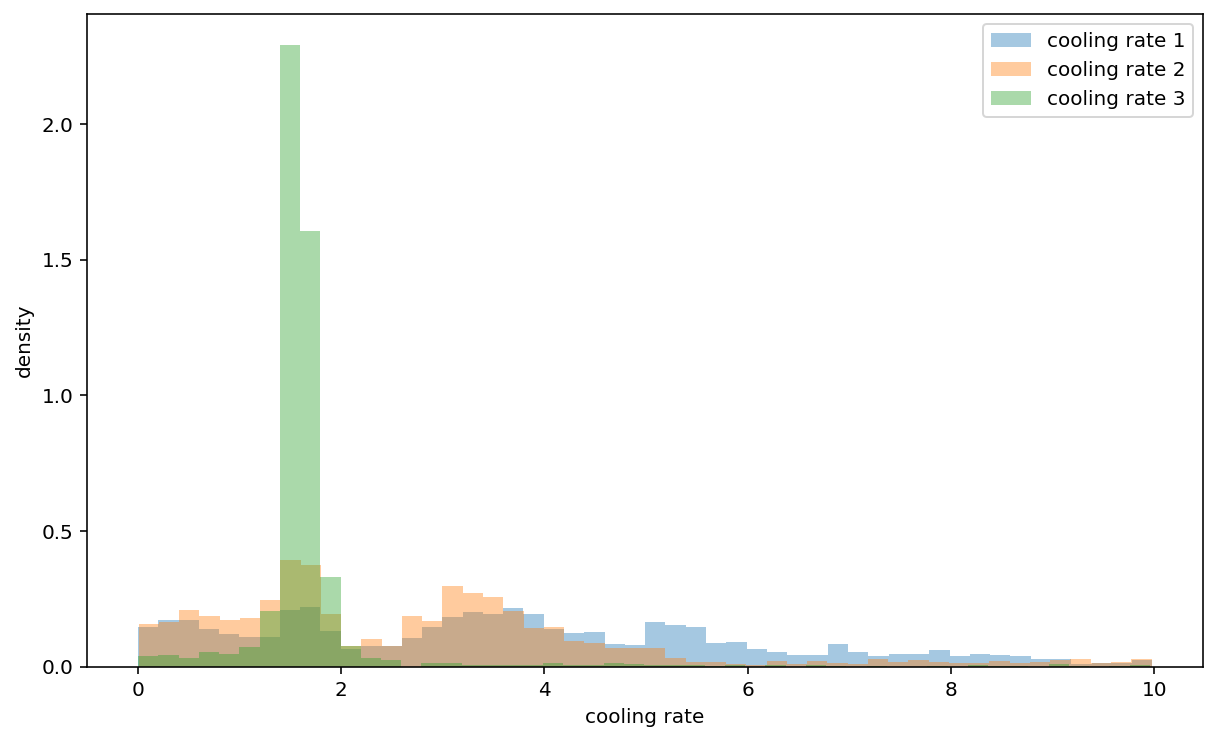

In [11]:
plt.figure(figsize=(10,6))
sns.distplot(Haliburton_trace_df['rate_1'], bins=50, kde=0, norm_hist=1, label='cooling rate 1')
sns.distplot(Haliburton_trace_df['rate_2'], bins=50, kde=0, norm_hist=1, label='cooling rate 2')
sns.distplot(Haliburton_trace_df['rate_3'], bins=50, kde=0, norm_hist=1, label='cooling rate 3')

plt.xlabel('cooling rate')
plt.ylabel('density')
plt.legend()
plt.show()

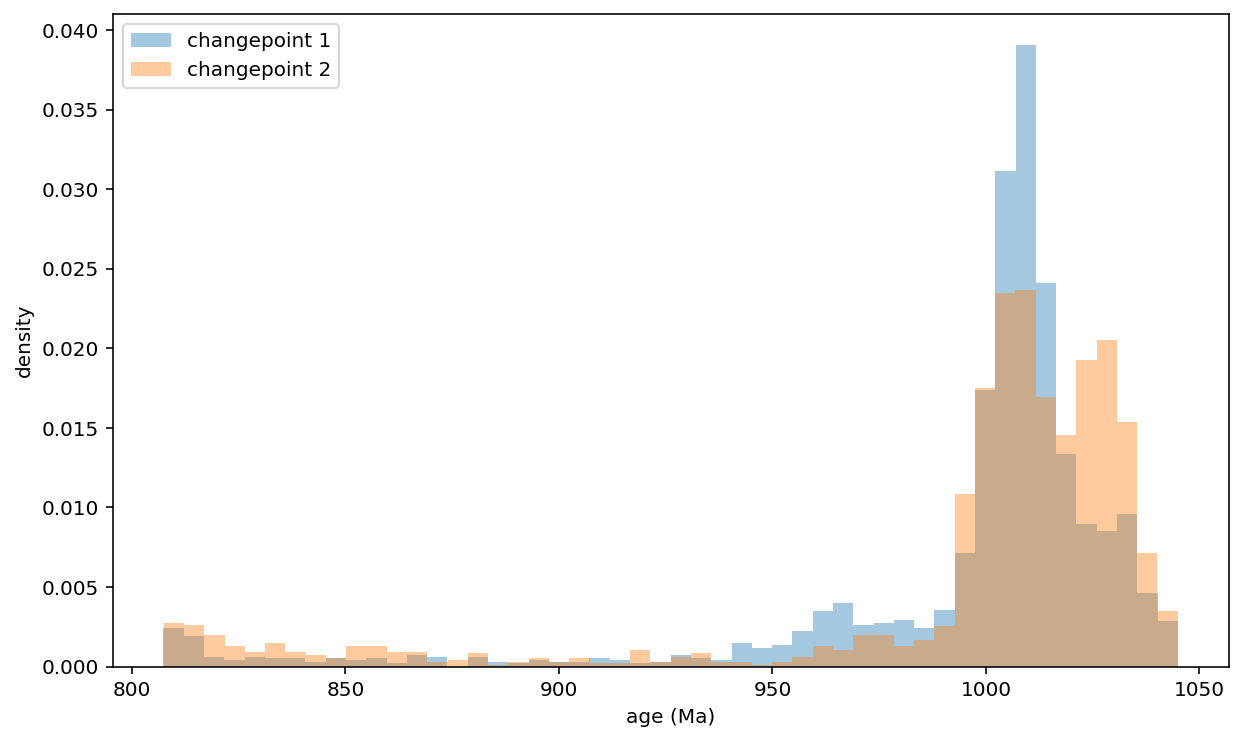

In [12]:
plt.figure(figsize=(10,6))
sns.distplot(Haliburton_trace_df['changepoint_1'], bins=50, kde=0, norm_hist=1, label='changepoint 1')
sns.distplot(Haliburton_trace_df['changepoint_2'], bins=50, kde=0, norm_hist=1, label='changepoint 2')

plt.xlabel('age (Ma)')
plt.ylabel('density')
plt.legend()
plt.show()

In [13]:
Haliburton_age_at_500 = find_age_at_temp(Haliburton_trace_df, Haliburton_nominal_ages, 500, n_rates=3)

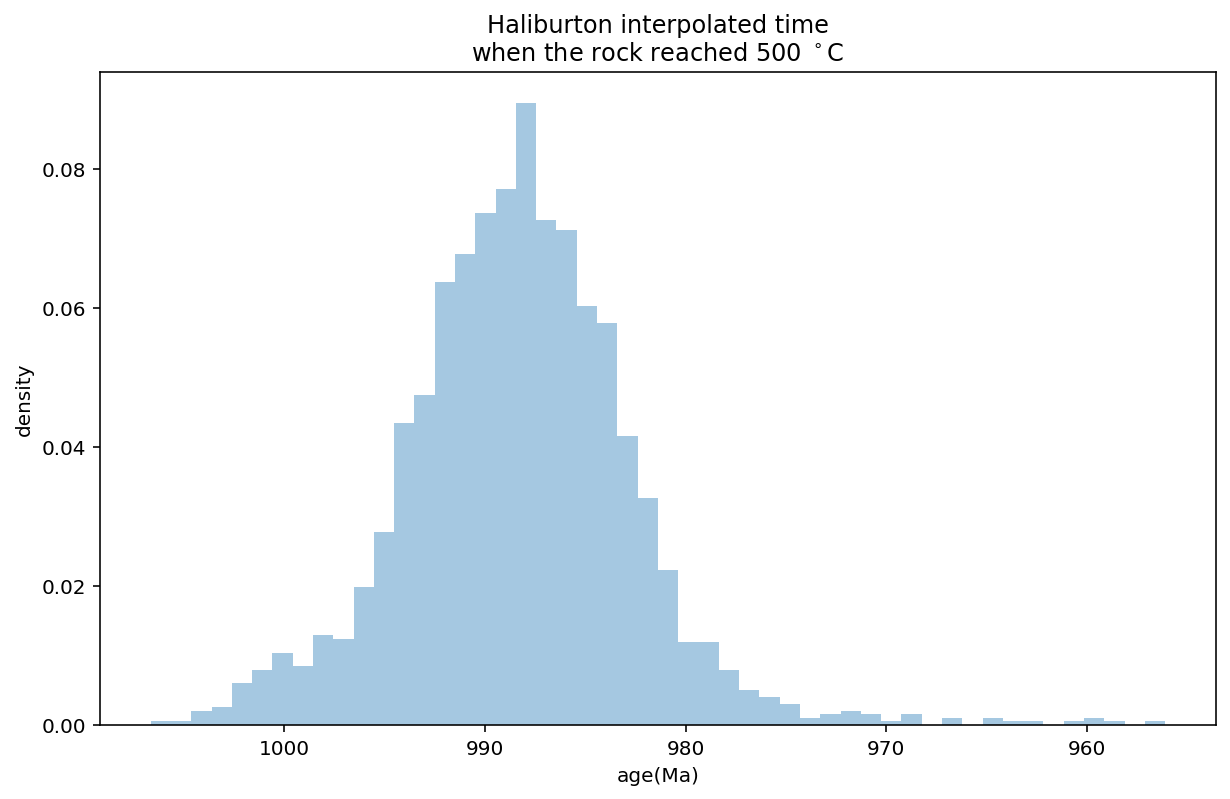

In [14]:
plt.figure(figsize=(10,6))
sns.distplot(Haliburton_age_at_500, kde=0, bins=50, norm_hist=1)
plt.xlabel('age(Ma)')
plt.ylabel('density')
plt.title('Haliburton interpolated time\nwhen the rock reached 500 $^\circ$C' )
plt.gca().invert_xaxis()
plt.show()

<Figure size 864x576 with 0 Axes>

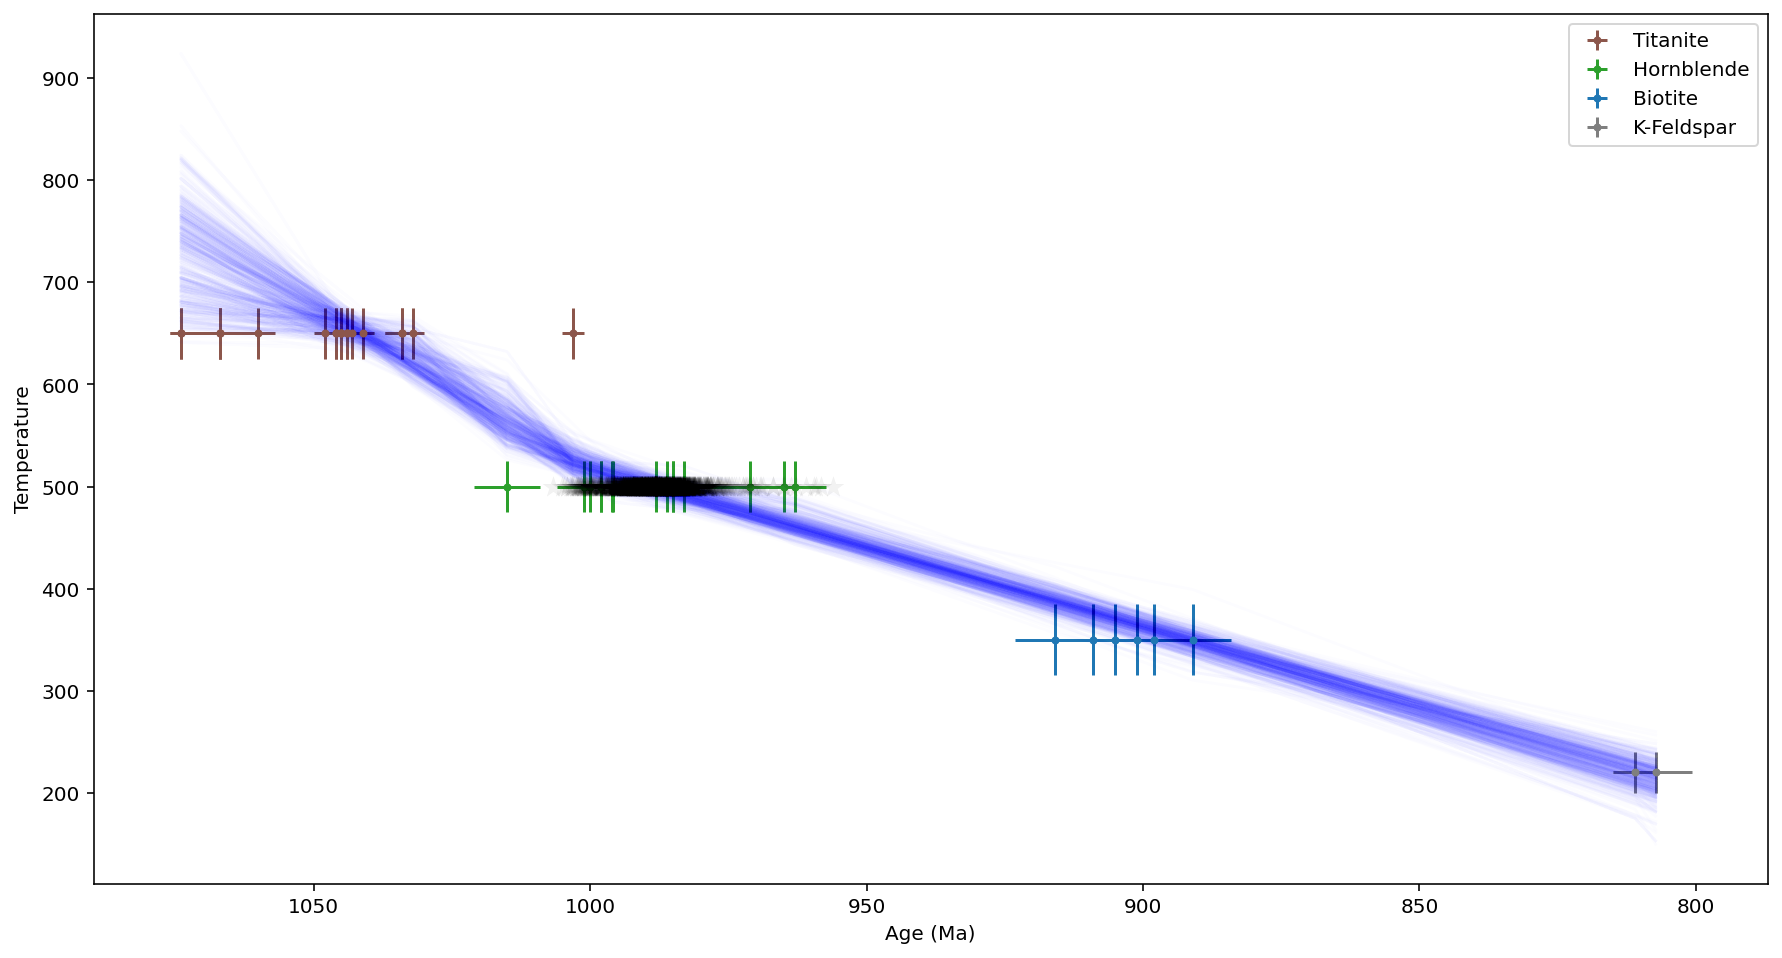

In [20]:
n_samples = 500
plt.figure(figsize=(12, 8))
plt.figure(figsize=(15, 8))

for i in Haliburton_ages.Age_Material.unique():
    this_material = Haliburton_ages[Haliburton_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)

    
for j in range(n_samples):
    this_row = Haliburton_trace_df.sample(n=1)
    y=[]
    this_start_age = this_row['start_age'].values[0]
    this_start_temp = this_row['start_temp'].values[0]

    for i in range(len(Haliburton_nominal_ages)):
        y.append(get_cooling_history_3(this_start_age, this_start_temp, 
                                  this_row['rate_1'].values[0], this_row['rate_2'].values[0], this_row['rate_3'].values[0],
                                  this_row['changepoint_1'].values[0], this_row['changepoint_2'].values[0], this_row['changepoint_3'].values[0],
                                             Haliburton_nominal_ages[i]))
    plt.plot([this_start_age]+Haliburton_nominal_ages, [this_start_temp]+y, color='b', alpha = 0.01)
plt.scatter(Haliburton_age_at_500, np.full(len(Haliburton_age_at_500), 500), 
            marker = '*', lw=0.1, c='k', alpha=0.05, edgecolor='k', s=120, zorder = 100)
plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
# plt.ylim(0, 1200)
# plt.xlim(1100, 750)
plt.legend()
plt.savefig('../figure/Haliburton_thermal_history.pdf')
plt.show()

## Anchor thermochron 2: Adirondack Highlands
- the younger titanites are due to small sizes - should be assigned lower unblocking temp
- authors prefer to use 650 for regular sized titanites and 550 for small sized titanites, we adopt this scheme here

In [21]:
Adirondack_highlands_ages = pd.read_csv('../data/thermochron_compilation/Adirondack_highlands_ages.csv')
Adirondack_highlands_ages = Adirondack_highlands_ages.sort_values(by='Age', ascending=0).reset_index(drop=1)
Adirondack_highlands_ages = Adirondack_highlands_ages[Adirondack_highlands_ages['Age_Material'] != 'Rutile'].reset_index(drop=1)

# Adirondack_highlands_ages['closure_temp'] = [closure_temp_bounds_dict[i][0] for i in Adirondack_highlands_ages['Age_Material']]
Adirondack_highlands_ages['closure_temp'] = [550 if (Adirondack_highlands_ages['Age_Material'][i] == 'Titanite') & (Adirondack_highlands_ages['Age'][i] < 1000) 
                                             else closure_temp_bounds_dict[Adirondack_highlands_ages['Age_Material'][i]][0] 
                                             for i in range(Adirondack_highlands_ages.shape[0])] 

Adirondack_highlands_ages['closure_temp_sigma'] = [closure_temp_bounds_dict[i][1] for i in Adirondack_highlands_ages['Age_Material']]

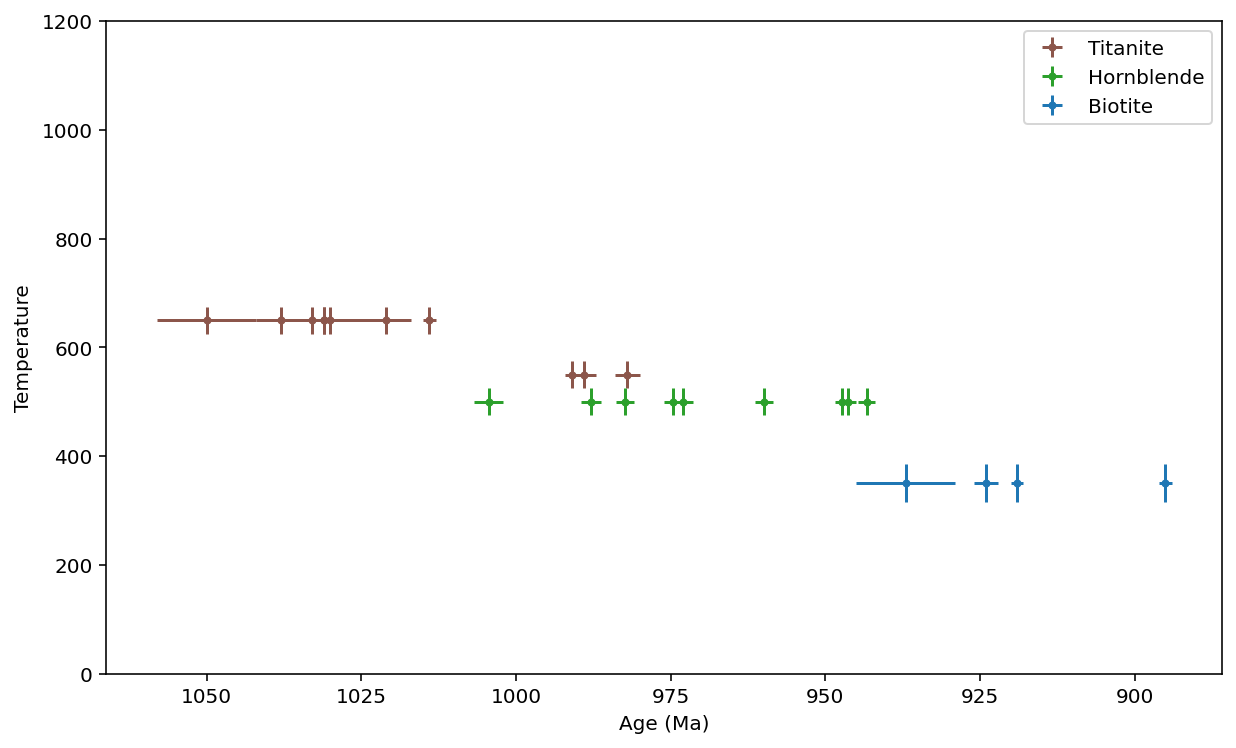

In [22]:
plt.figure(figsize=(10, 6))
for i in Adirondack_highlands_ages.Age_Material.unique():
    this_material = Adirondack_highlands_ages[Adirondack_highlands_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)
plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
plt.ylim(0, 1200)
# plt.xlim(1100, 750)
plt.legend()
plt.show()

In [23]:
Adirondack_highlands_nominal_ages = Adirondack_highlands_ages['Age'].tolist()
Adirondack_highlands_sigmas = list((Adirondack_highlands_ages['Error_Minus']+Adirondack_highlands_ages['Error_Plus']).to_numpy()/2)
Adirondack_highlands_temps = Adirondack_highlands_ages['closure_temp']
Adirondack_highlands_temp_sigmas = Adirondack_highlands_ages['closure_temp_sigma']

In [24]:
with pm.Model() as model:
    
    start_index = np.argmax(Adirondack_highlands_nominal_ages)
    start_age = pm.Normal('start_age', max(Adirondack_highlands_nominal_ages), Adirondack_highlands_sigmas[start_index])
    start_temp = pm.Normal('start_temp', Adirondack_highlands_temps[start_index], Adirondack_highlands_temp_sigmas[start_index])
    
    rate_1 = pm.Uniform('rate_1', lower=0., upper=10)
    rate_2 = pm.Uniform('rate_2', lower=0., upper=10)
    rate_3 = pm.Uniform('rate_3', lower=0., upper=10)
    
    changepoint_1 = pm.Uniform('changepoint_1', lower=min(Adirondack_highlands_nominal_ages), upper=max(Adirondack_highlands_nominal_ages))
    changepoint_2 = pm.Uniform('changepoint_2', lower=min(Adirondack_highlands_nominal_ages), upper=max(Adirondack_highlands_nominal_ages))
    changepoint_3 = pm.Uniform('changepoint_3', lower=0., upper=.1)
    
    for i, (age, sigma, temp, temp_sigma) in enumerate(zip(Adirondack_highlands_nominal_ages, Adirondack_highlands_sigmas, 
                                                           Adirondack_highlands_temps, Adirondack_highlands_temp_sigmas)):
        print('measurement'+str(i), age, sigma, temp, temp_sigma)
        this_age = pm.Normal('age'+str(i), age, sigma)
        observed_temp = pm.Normal('measurement'+str(i), 
                                  cooling_history_3(start_age, start_temp, 
                                                    rate_1, rate_2, rate_3,
                                                    changepoint_1, changepoint_2, changepoint_3,
                                                    this_age), 
                                  np.array(temp_sigma),
                                  observed=temp)
#     Adirondack_highlands_trace = pm.sample(5000, cores=1, chains=1, tune=1000)

measurement0 1050.0 8.0 650 25.0
measurement1 1038.0 4.0 650 25.0
measurement2 1033.0 4.0 650 25.0
measurement3 1031.0 3.0 650 25.0
measurement4 1031.0 10.0 650 25.0
measurement5 1030.0 4.0 650 25.0
measurement6 1021.0 4.0 650 25.0
measurement7 1014.0 1.0 650 25.0
measurement8 1004.41 2.31 500 25.0
measurement9 991.0 1.0 550 25.0
measurement10 989.0 2.0 550 25.0
measurement11 987.87 1.62 500 25.0
measurement12 982.38 1.5 500 25.0
measurement13 982.0 2.0 550 25.0
measurement14 974.68 1.34 500 25.0
measurement15 973.0 1.63 500 25.0
measurement16 959.96 1.44 500 25.0
measurement17 947.27 1.12 500 25.0
measurement18 946.28 1.27 500 25.0
measurement19 943.3 1.37 500 25.0
measurement20 937.0 8.0 350 35.0
measurement21 924.0 2.0 350 35.0
measurement22 919.0 1.0 350 35.0
measurement23 895.0 1.0 350 35.0


In [25]:
# pm.save_trace(Adirondack_highlands_trace, 'code_output/Adirondack_highlands_trace')

In [26]:
Adirondack_highlands_trace_df = load_trace('./code_output/Adirondack_highlands_trace/0/samples.npz')
# Adirondack_highlands_trace_df.head()

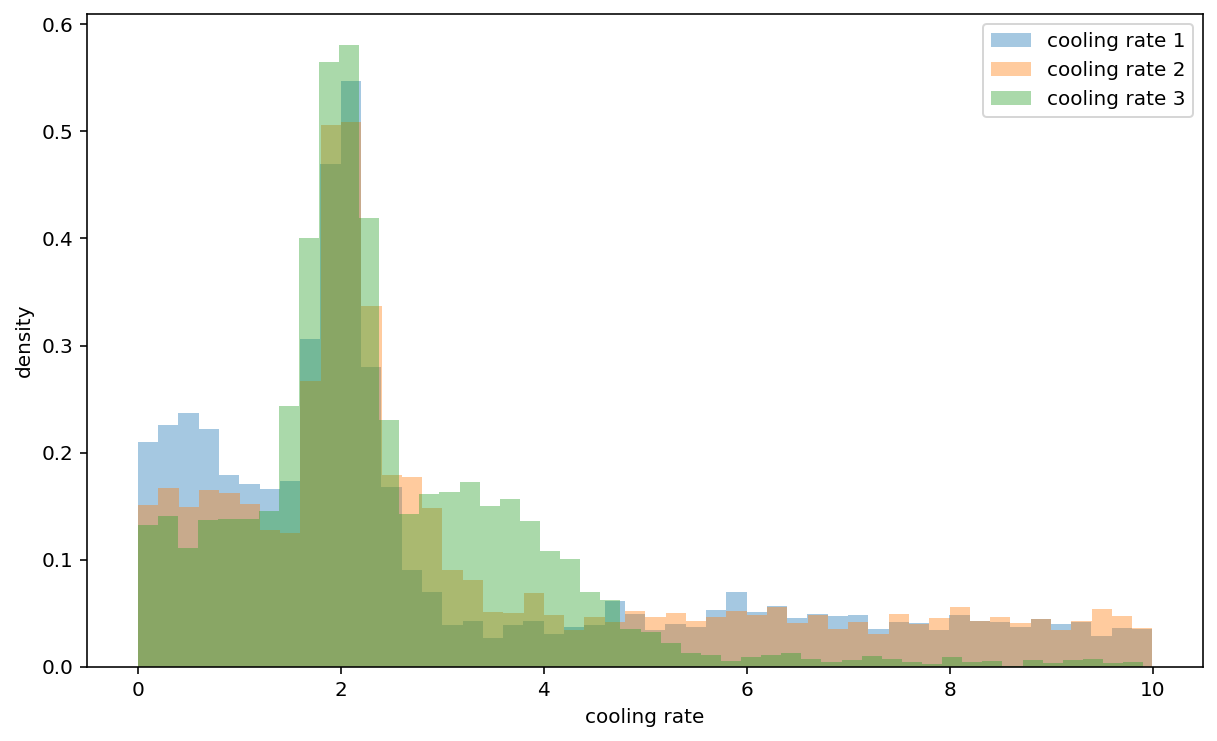

In [27]:
plt.figure(figsize=(10,6))
sns.distplot(Adirondack_highlands_trace_df['rate_1'], bins=50, kde=0, norm_hist=1, label='cooling rate 1')
sns.distplot(Adirondack_highlands_trace_df['rate_2'], bins=50, kde=0, norm_hist=1, label='cooling rate 2')
sns.distplot(Adirondack_highlands_trace_df['rate_3'], bins=50, kde=0, norm_hist=1, label='cooling rate 3')

plt.xlabel('cooling rate')
plt.ylabel('density')
plt.legend()
plt.show()

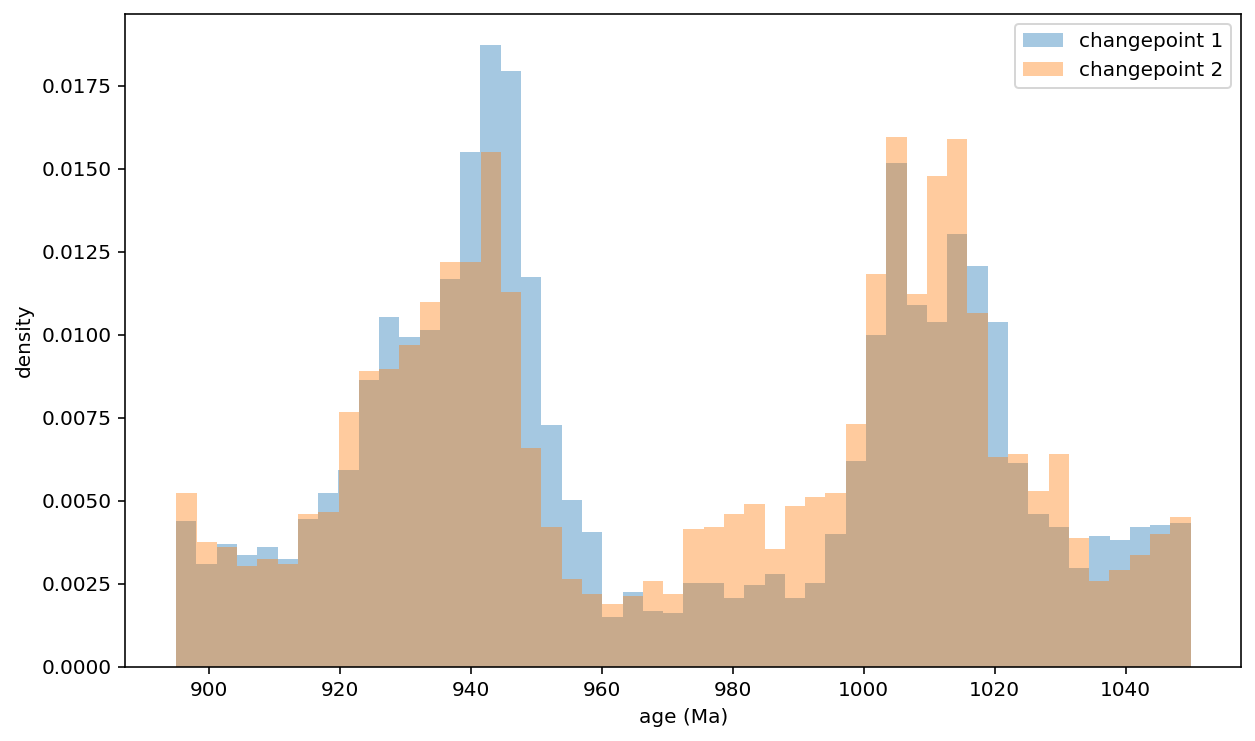

In [28]:
plt.figure(figsize=(10,6))
sns.distplot(Adirondack_highlands_trace_df['changepoint_1'], bins=50, kde=0, norm_hist=1, label='changepoint 1')
sns.distplot(Adirondack_highlands_trace_df['changepoint_2'], bins=50, kde=0, norm_hist=1, label='changepoint 2')

plt.xlabel('age (Ma)')
plt.ylabel('density')
plt.legend()
plt.show()

In [29]:
Adirondack_highlands_age_at_500 = find_age_at_temp(Adirondack_highlands_trace_df, Adirondack_highlands_nominal_ages, 500, n_rates=3)

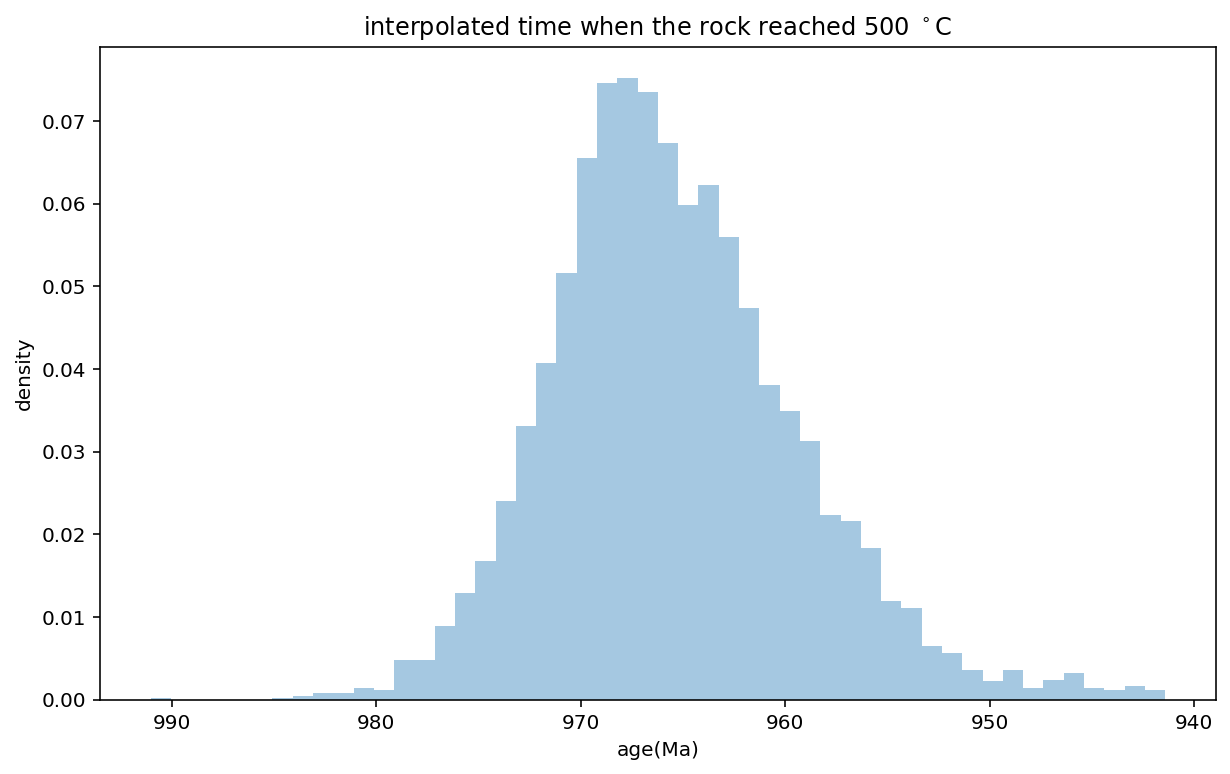

In [30]:
plt.figure(figsize=(10,6))
sns.distplot(Adirondack_highlands_age_at_500, kde=0, bins=50, norm_hist=1)
plt.xlabel('age(Ma)')
plt.ylabel('density')
plt.title('interpolated time when the rock reached 500 $^\circ$C' )
plt.gca().invert_xaxis()
plt.show()

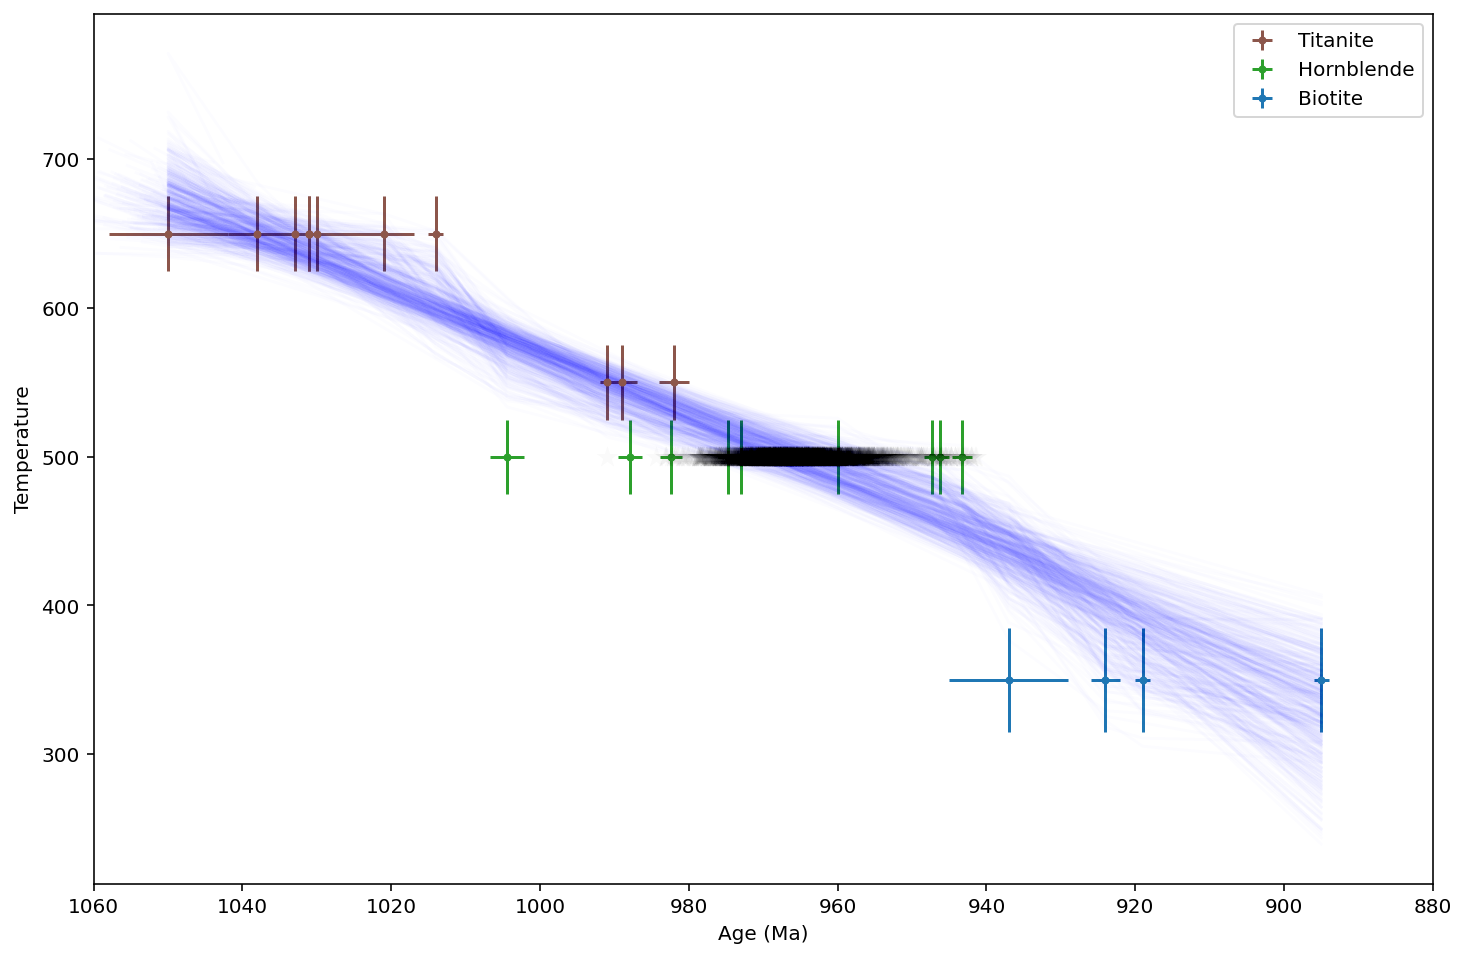

In [66]:
n_samples = 500
plt.figure(figsize=(12, 8))

for i in Adirondack_highlands_ages.Age_Material.unique():
    this_material = Adirondack_highlands_ages[Adirondack_highlands_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)

    
for j in range(n_samples):
    this_row = Adirondack_highlands_trace_df.sample(n=1)
    y=[]
    this_start_age = this_row['start_age'].values[0]
    this_start_temp = this_row['start_temp'].values[0]

    for i in range(len(Adirondack_highlands_nominal_ages)):
        y.append(get_cooling_history_3(this_start_age, this_start_temp, 
                                  this_row['rate_1'].values[0], this_row['rate_2'].values[0], this_row['rate_3'].values[0],
                                  this_row['changepoint_1'].values[0], this_row['changepoint_2'].values[0], this_row['changepoint_3'].values[0],
                                             Adirondack_highlands_nominal_ages[i]))
    plt.plot([this_start_age]+Adirondack_highlands_nominal_ages, [this_start_temp]+y, color='b', alpha = 0.01)
plt.scatter(Adirondack_highlands_age_at_500, np.full(len(Adirondack_highlands_age_at_500), 500),
            marker = '*', lw=0.1, c='k', alpha=0.02, edgecolor='k', s=120, zorder = 100)
plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
# plt.ylim(0, 1200)
plt.xlim(1060, 880)
plt.legend()
plt.savefig('../figure/Adirondack_highlands_thermal_history.pdf')
plt.show()

## Anchor thermochron 3: Whitestone anorthosite and diorite

In [32]:
Whitestone_ages = pd.read_csv('../data/thermochron_compilation/Whitestone_ages.csv')
Whitestone_ages = Whitestone_ages.sort_values(by='Age', ascending=0).reset_index(drop=1)

Whitestone_ages['closure_temp'] = [closure_temp_bounds_dict[i][0] for i in Whitestone_ages['Age_Material']]
Whitestone_ages['closure_temp_sigma'] = [closure_temp_bounds_dict[i][1] for i in Whitestone_ages['Age_Material']]

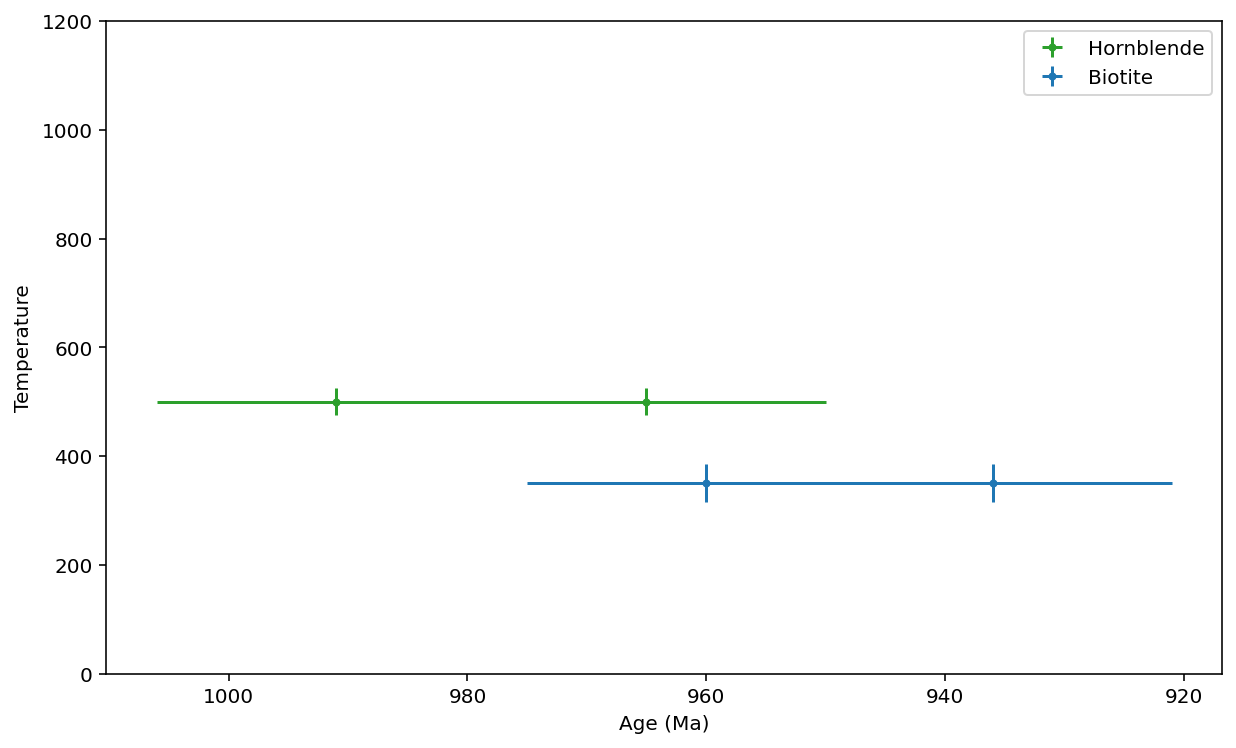

In [33]:
plt.figure(figsize=(10, 6))
for i in Whitestone_ages.Age_Material.unique():
    this_material = Whitestone_ages[Whitestone_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)
plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
plt.ylim(0, 1200)
# plt.xlim(1100, 750)
plt.legend()
plt.show()

In [34]:
Whitestone_nominal_ages = Whitestone_ages['Age'].tolist()
Whitestone_sigmas = list((Whitestone_ages['Error_Minus']+Whitestone_ages['Error_Plus']).to_numpy()/2)
Whitestone_temps = Whitestone_ages['closure_temp'].tolist()
Whitestone_temp_sigmas = Whitestone_ages['closure_temp_sigma'].tolist()

In [35]:
with pm.Model() as model:
    
    start_index = np.argmax(Whitestone_nominal_ages)
    start_age = pm.Normal('start_age', max(Whitestone_nominal_ages), Whitestone_sigmas[start_index])
    start_temp = pm.Normal('start_temp', Whitestone_temps[start_index], Whitestone_temp_sigmas[start_index])
    
    rate_1 = pm.Uniform('rate_1', lower=0., upper=10)
        
    for i, (age, sigma, temp, temp_sigma) in enumerate(zip(Whitestone_nominal_ages, Whitestone_sigmas, Whitestone_temps, Whitestone_temp_sigmas)):
        print('measurement'+str(i), age, sigma, temp, temp_sigma)
        this_age = pm.Normal('age'+str(i), age, sigma)
        observed_temp = pm.Normal('measurement'+str(i), 
                                  cooling_history_1(start_age, start_temp, rate_1, this_age), 
                                  temp_sigma,
                                  observed=temp)
#     Whitestone_trace = pm.sample(2000, cores=1, chains=1, tune=1000)

measurement0 991 15.0 500 25.0
measurement1 965 15.0 500 25.0
measurement2 960 15.0 350 35.0
measurement3 936 15.0 350 35.0


In [36]:
# pm.save_trace(Whitestone_trace, 'code_output/Whitestone_trace')

In [37]:
Whitestone_trace_df = load_trace('./code_output/Whitestone_trace/0/samples.npz')

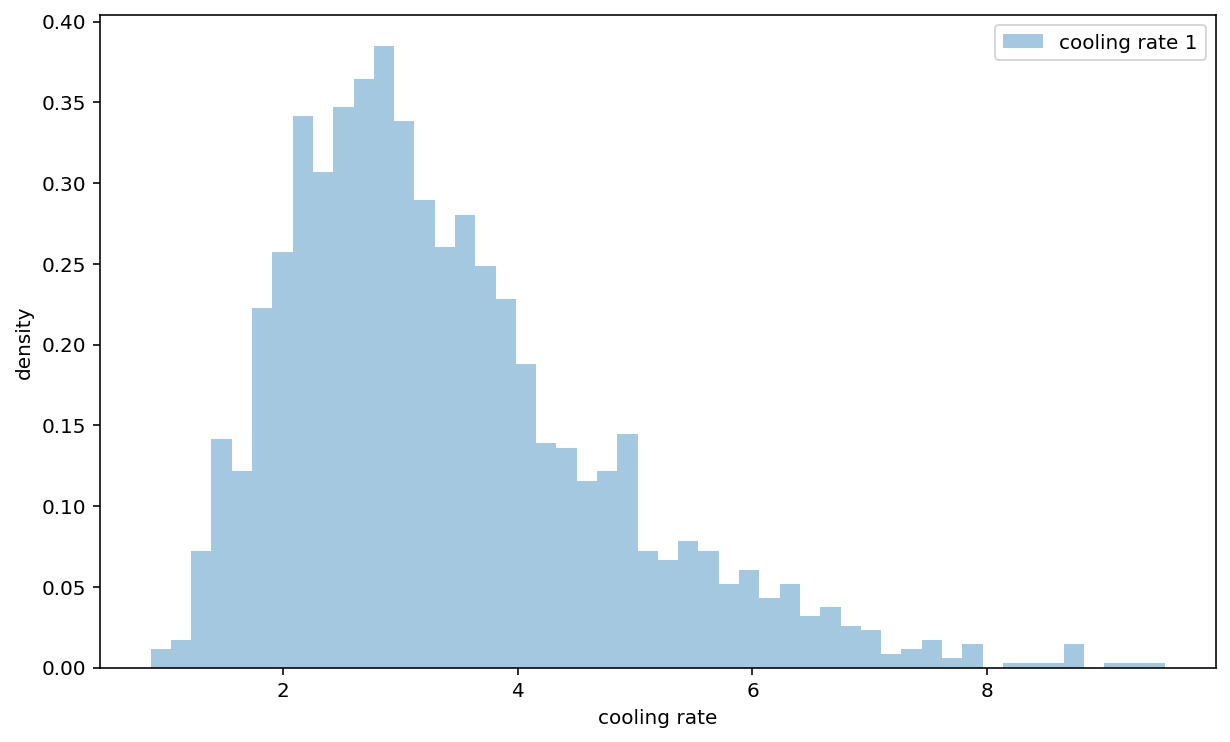

In [38]:
plt.figure(figsize=(10,6))
sns.distplot(Whitestone_trace_df['rate_1'], bins=50, kde=0, norm_hist=1, label='cooling rate 1')
plt.xlabel('cooling rate')
plt.ylabel('density')
plt.legend()
plt.show()

In [39]:
Whitestone_age_at_500 = find_age_at_temp(Whitestone_trace_df, Whitestone_nominal_ages, 500, n_rates=1)

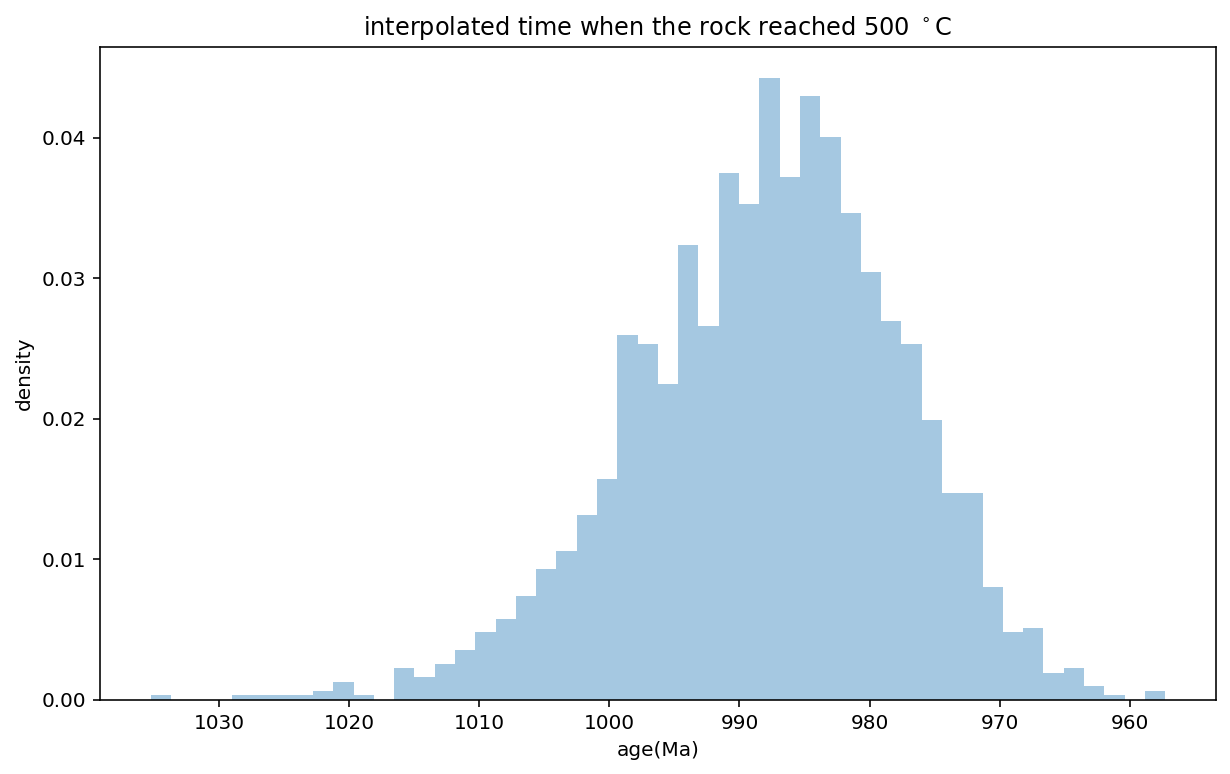

In [40]:
plt.figure(figsize=(10,6))
sns.distplot(Whitestone_age_at_500, kde=0, bins=50, norm_hist=1)
plt.xlabel('age(Ma)')
plt.ylabel('density')
plt.title('interpolated time when the rock reached 500 $^\circ$C' )
plt.gca().invert_xaxis()
plt.show()

<Figure size 864x576 with 0 Axes>

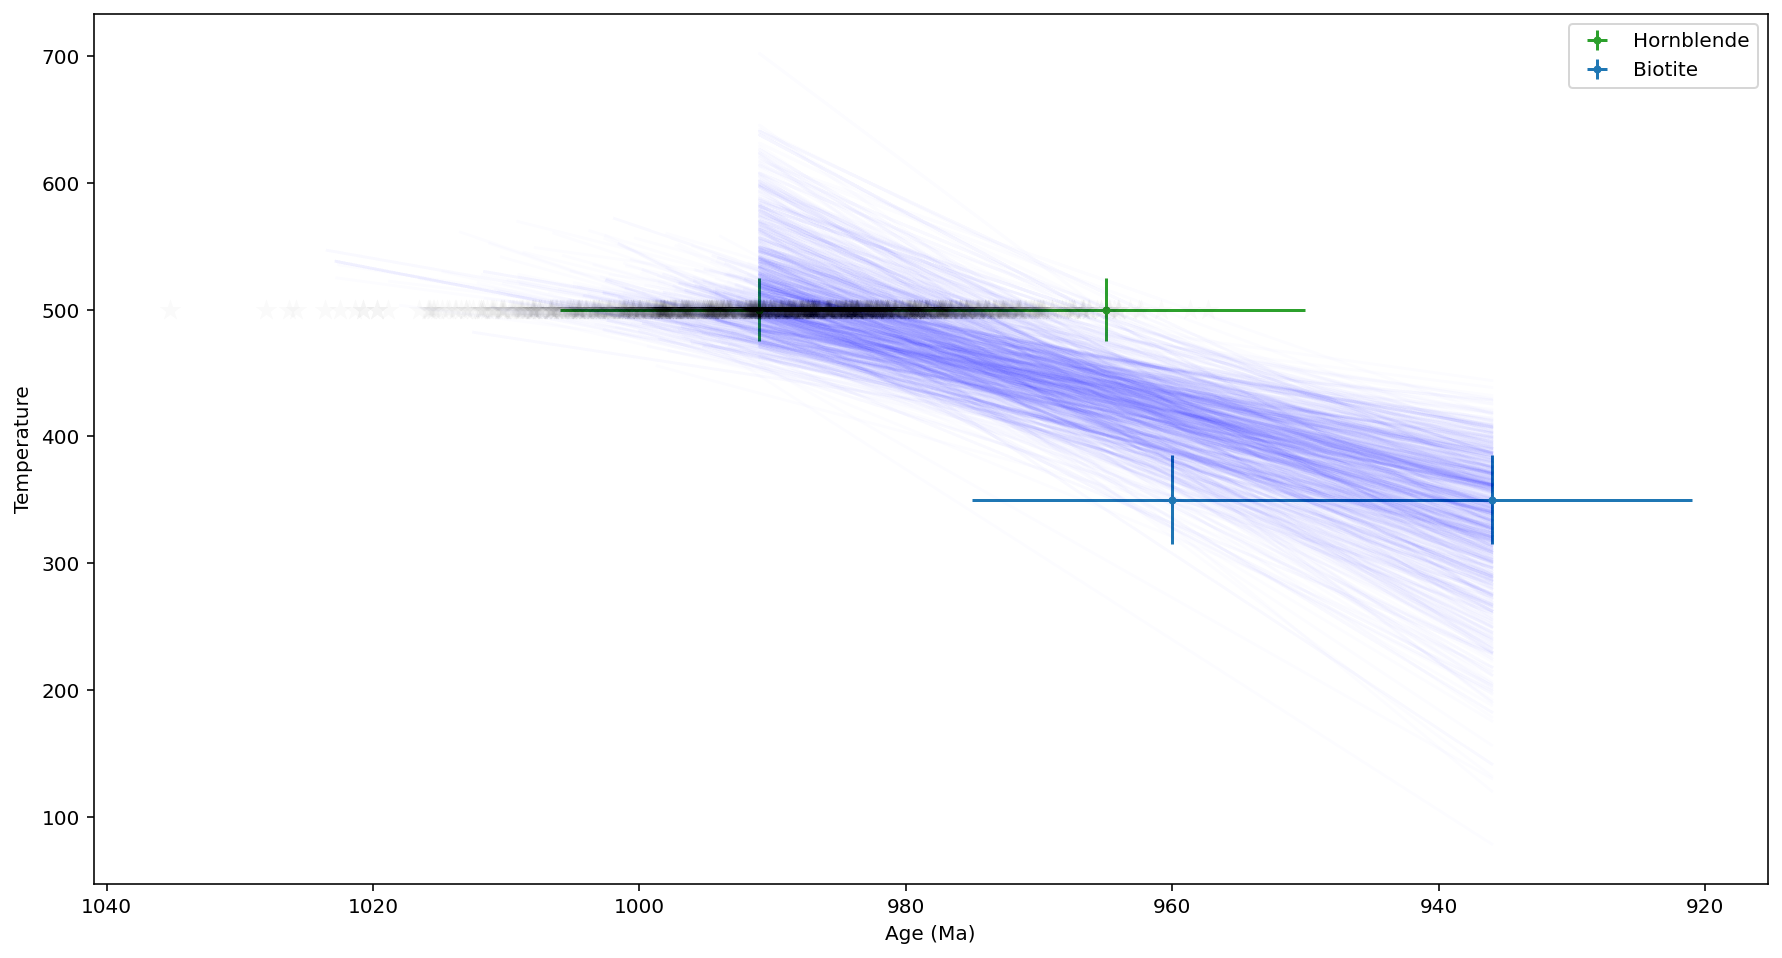

In [68]:
n_samples = 1000
plt.figure(figsize=(12, 8))
plt.figure(figsize=(15, 8))

for i in Whitestone_ages.Age_Material.unique():
    this_material = Whitestone_ages[Whitestone_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)


for j in range(n_samples):
    this_row = Whitestone_trace_df.sample(n=1)
    y = []
    this_start_age = this_row['start_age'].values[0]
    this_start_temp = this_row['start_temp'].values[0]
    this_rate = this_row['rate_1'].values[0]
    for i in range(len(Whitestone_nominal_ages)):
        y.append(get_cooling_history_1(this_start_age, this_start_temp, 
                                  this_rate,
                                  Whitestone_nominal_ages[i]))
    plt.plot([this_start_age]+Whitestone_nominal_ages, [this_start_temp]+y, color='b', alpha = 0.01)
    
plt.scatter(Whitestone_age_at_500, np.full(len(Whitestone_age_at_500), 500), marker = '*', lw=0.1, c='k', alpha=0.02, edgecolor='k', s=120, zorder = 100)
plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
plt.legend()
plt.savefig('../figure/Whitestone_thermal_history.pdf')

plt.show()

## Anchor thermochron 4: Lac Allard and St. Urbain anorthosite

In [42]:
Allard_Urbain_ages = pd.read_csv('../data/thermochron_compilation/Allard_Urbain_ages.csv')
Allard_Urbain_ages = Allard_Urbain_ages.sort_values(by='Age', ascending=0)
Allard_Urbain_ages = Allard_Urbain_ages[~Allard_Urbain_ages['Age_Material'].str.contains('Plagioclase')].reset_index(drop=1)
Allard_Urbain_ages['closure_temp'] = [closure_temp_bounds_dict[i][0] for i in Allard_Urbain_ages['Age_Material']]
Allard_Urbain_ages['closure_temp_sigma'] = [closure_temp_bounds_dict[i][1] for i in Allard_Urbain_ages['Age_Material']]
Allard_Urbain_ages = Allard_Urbain_ages.sort_values(by=['Age_Material', 'Age'], ascending=False).reset_index(drop=1)
# Allard_Urbain_ages

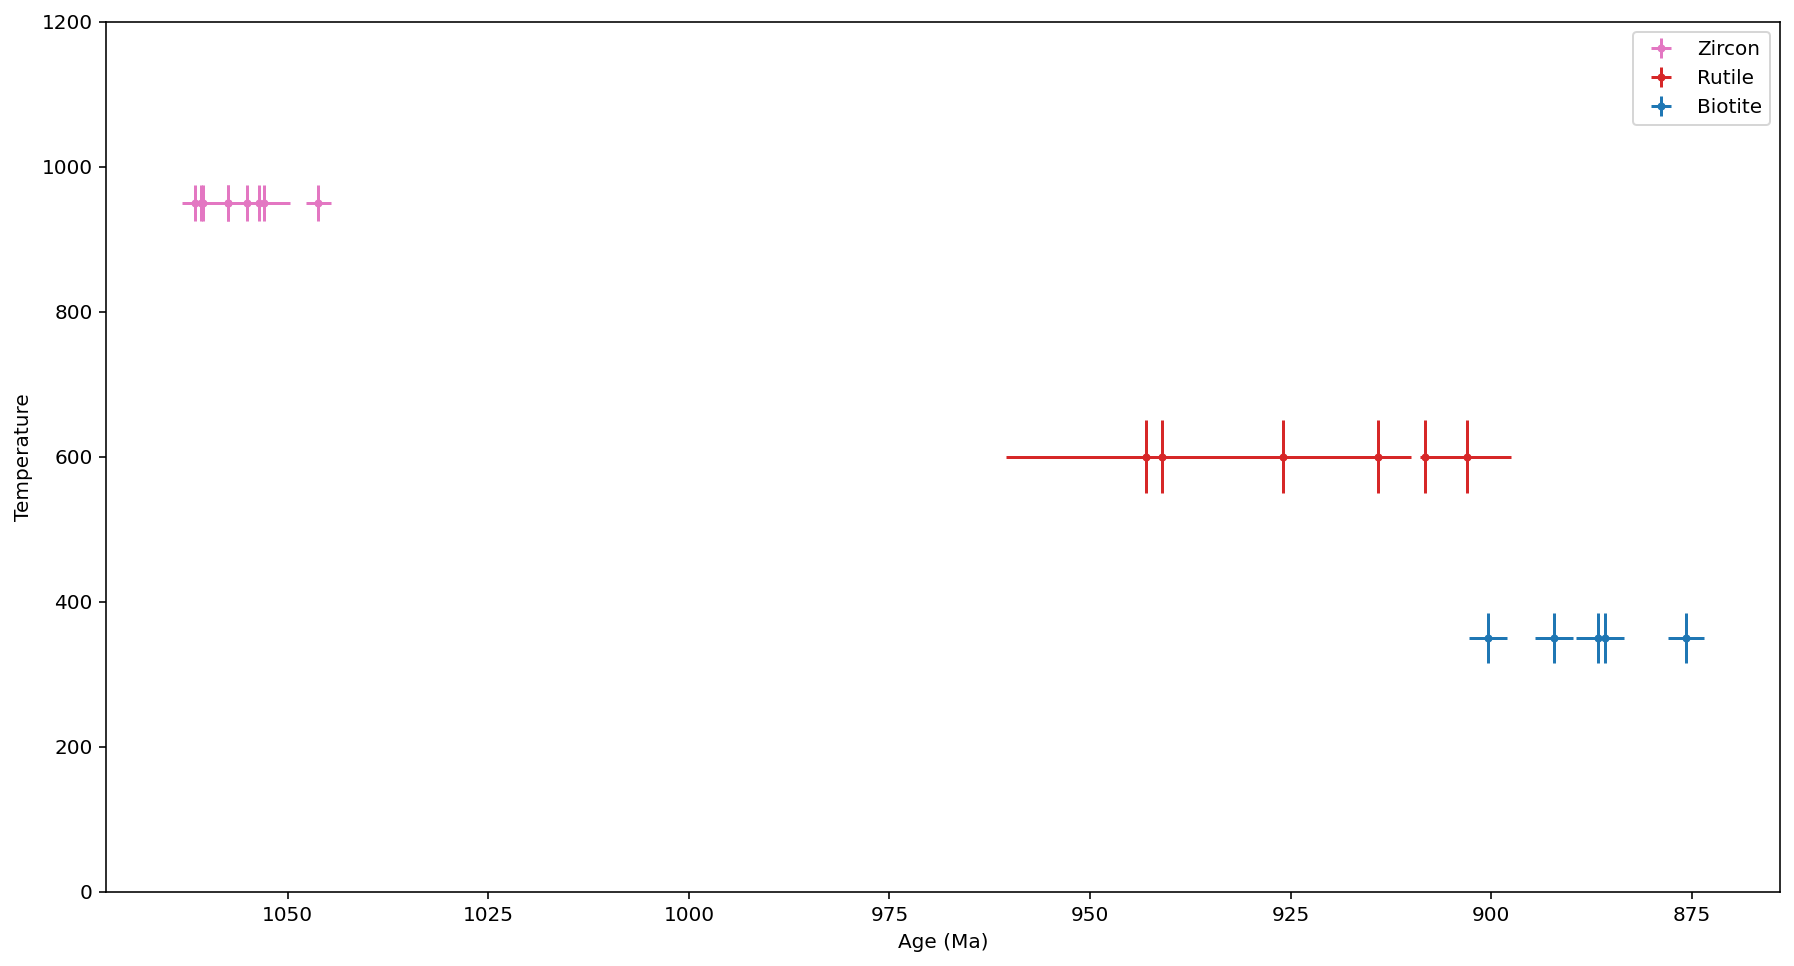

In [43]:
plt.figure(figsize=(15, 8))
for i in Allard_Urbain_ages.Age_Material.unique():
    this_material = Allard_Urbain_ages[Allard_Urbain_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)
plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.ylim(0, 1200)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [44]:
Allard_Urbain_nominal_ages = Allard_Urbain_ages['Age'].tolist()
Allard_Urbain_sigmas = list((Allard_Urbain_ages['Error_Minus']+Allard_Urbain_ages['Error_Plus']).to_numpy()/2)
Allard_Urbain_temps = Allard_Urbain_ages['closure_temp'] 
Allard_Urbain_temp_sigmas = Allard_Urbain_ages['closure_temp_sigma']

In [45]:
with pm.Model() as model:
    
    start_index = np.argmax(Allard_Urbain_nominal_ages)
    start_age = pm.Normal('start_age', max(Allard_Urbain_nominal_ages), Allard_Urbain_sigmas[start_index])
    start_temp = pm.Normal('start_temp', Allard_Urbain_temps[start_index], Allard_Urbain_temp_sigmas[start_index])
    
    rate_1 = pm.Uniform('rate_1', lower=0., upper=10)
    rate_2 = pm.Uniform('rate_2', lower=0., upper=10)
    
    changepoint_1 = pm.Uniform('changepoint_1', lower=min(Allard_Urbain_nominal_ages), upper=max(Allard_Urbain_nominal_ages))
    changepoint_2 = pm.Uniform('changepoint_2', lower=0., upper=.1)
    
    for i, (age, sigma, temp, temp_sigma) in enumerate(zip(Allard_Urbain_nominal_ages, Allard_Urbain_sigmas, Allard_Urbain_temps, Allard_Urbain_temp_sigmas)):
        print('measurement'+str(i), age, sigma, temp, temp_sigma)
        this_age = pm.Normal('age'+str(i), age, sigma)
        observed_temp = pm.Normal('measurement'+str(i), 
                                  cooling_history_2(start_age, start_temp, rate_1, rate_2, changepoint_1, changepoint_2, this_age), 
                                  np.array(temp_sigma),
                                  observed=temp)
#     Allard_Urbain_trace = pm.sample(2000, cores=1, chains=1, tune=1000)

measurement0 1061.6 1.5 950 25.0
measurement1 1060.8 1.4 950 25.0
measurement2 1060.5 0.95 950 25.0
measurement3 1057.4 2.85 950 25.0
measurement4 1057.4 0.75 950 25.0
measurement5 1055.0 1.2 950 25.0
measurement6 1053.6 1.3 950 25.0
measurement7 1052.9 3.25 950 25.0
measurement8 1046.2 1.55 950 25.0
measurement9 943.0 12.5 600 50.0
measurement10 941.0 19.5 600 50.0
measurement11 926.0 16.0 600 50.0
measurement12 914.1 1.5 600 50.0
measurement13 908.3 0.55 600 50.0
measurement14 903.0 5.5 600 50.0
measurement15 900.4 2.4 350 35.0
measurement16 892.2 2.35 350 35.0
measurement17 886.7 2.7 350 35.0
measurement18 885.8 2.3 350 35.0
measurement19 875.7 2.25 350 35.0


In [46]:
# pm.save_trace(Allard_Urbain_trace, 'code_output/Allard_Urbain_trace')

In [47]:
Allard_Urbain_trace_df = load_trace('./code_output/Allard_Urbain_trace/0/samples.npz')

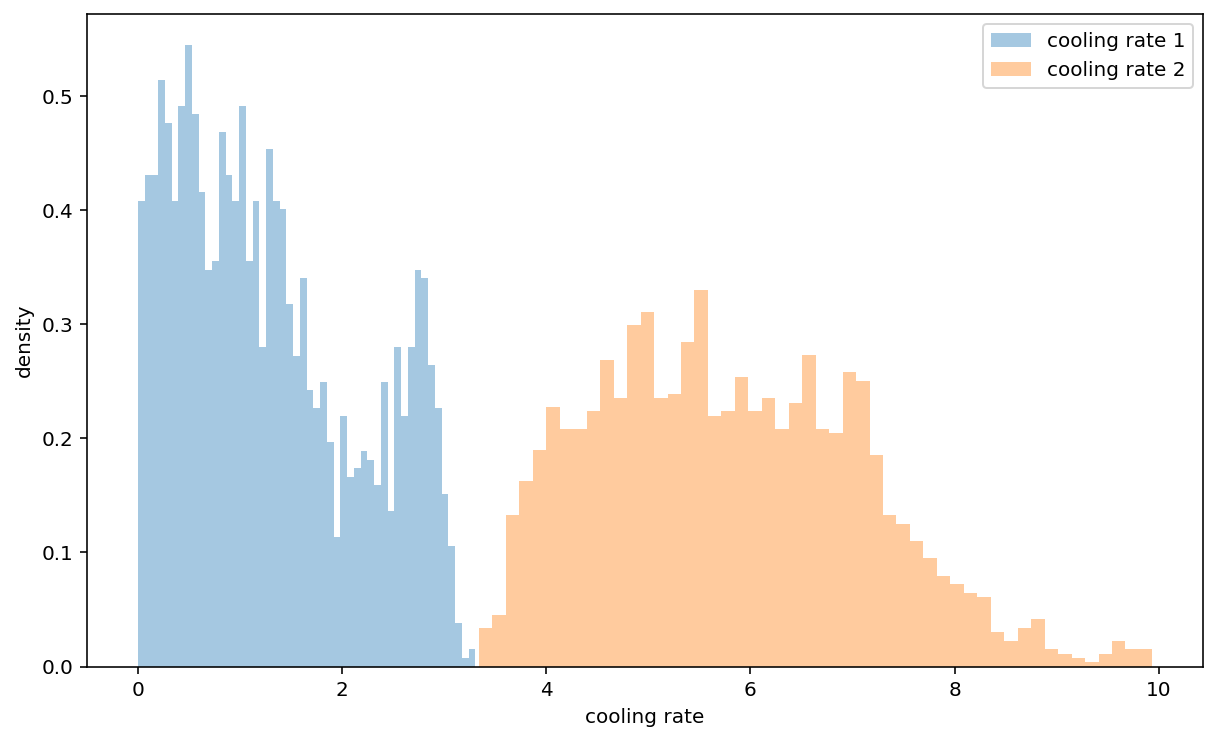

In [48]:
plt.figure(figsize=(10,6))
sns.distplot(Allard_Urbain_trace_df['rate_1'], bins=50, kde=0, norm_hist=1, label='cooling rate 1')
sns.distplot(Allard_Urbain_trace_df['rate_2'], bins=50, kde=0, norm_hist=1, label='cooling rate 2')
plt.xlabel('cooling rate')
plt.ylabel('density')
plt.legend()
plt.show()

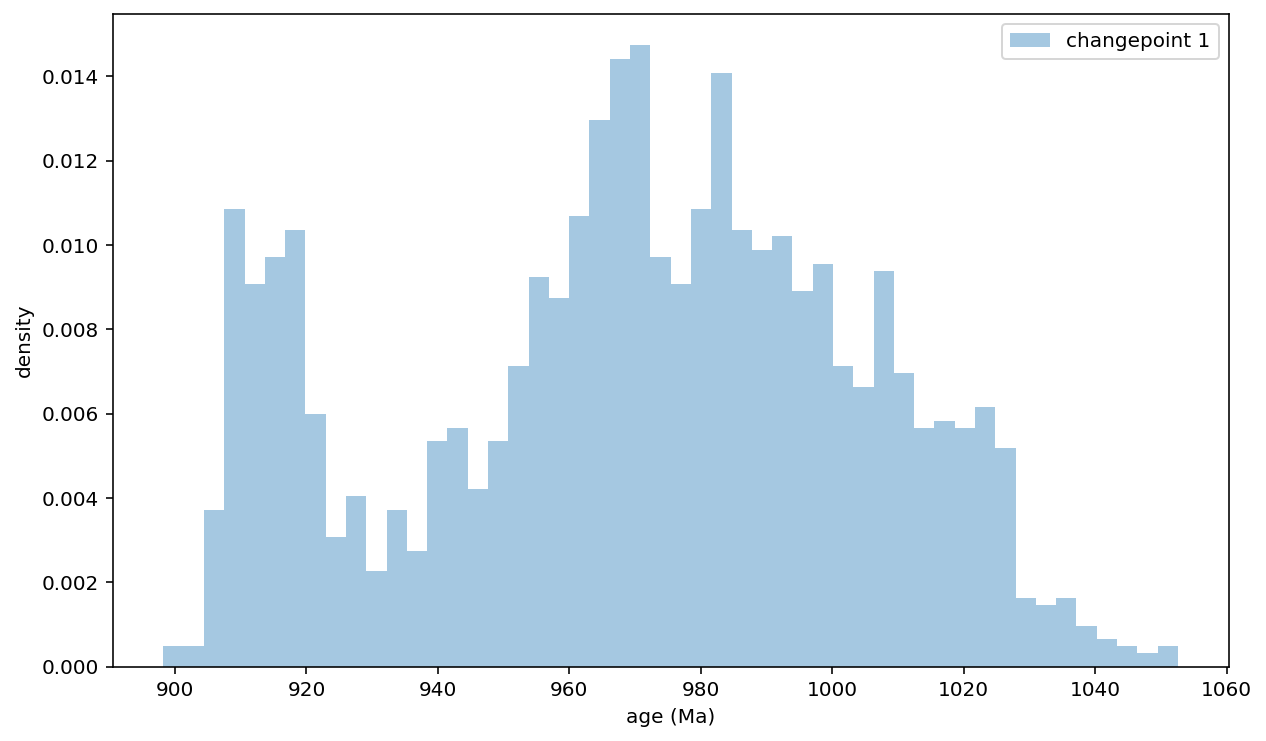

In [49]:
plt.figure(figsize=(10,6))
sns.distplot(Allard_Urbain_trace_df['changepoint_1'], bins=50, kde=0, norm_hist=1, label='changepoint 1')
plt.xlabel('age (Ma)')
plt.ylabel('density')
plt.legend()
plt.show()

In [50]:
Allard_Urbain_age_at_500 = find_age_at_temp(Allard_Urbain_trace_df, Allard_Urbain_nominal_ages, 500, n_rates=2)

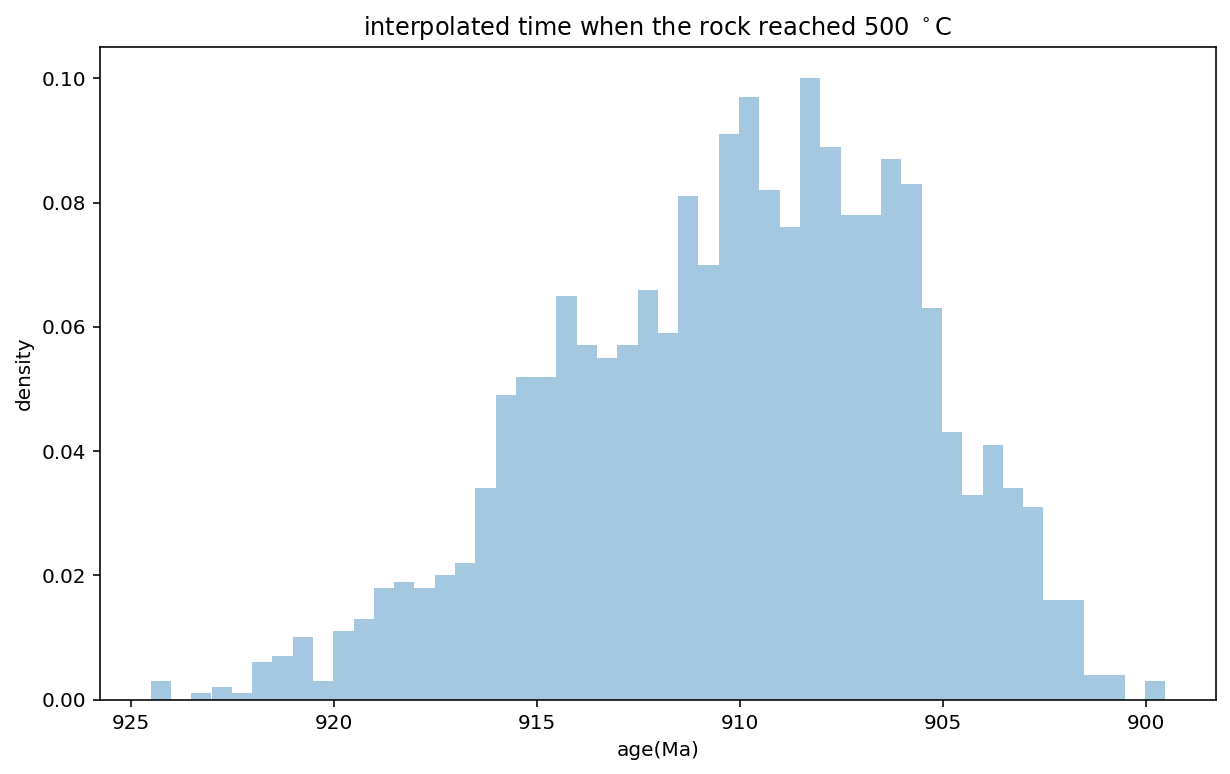

In [51]:
plt.figure(figsize=(10,6))
sns.distplot(Allard_Urbain_age_at_500, kde=0, bins=50, norm_hist=1)
plt.xlabel('age(Ma)')
plt.ylabel('density')
plt.title('interpolated time when the rock reached 500 $^\circ$C' )
plt.gca().invert_xaxis()
plt.show()

<Figure size 864x576 with 0 Axes>

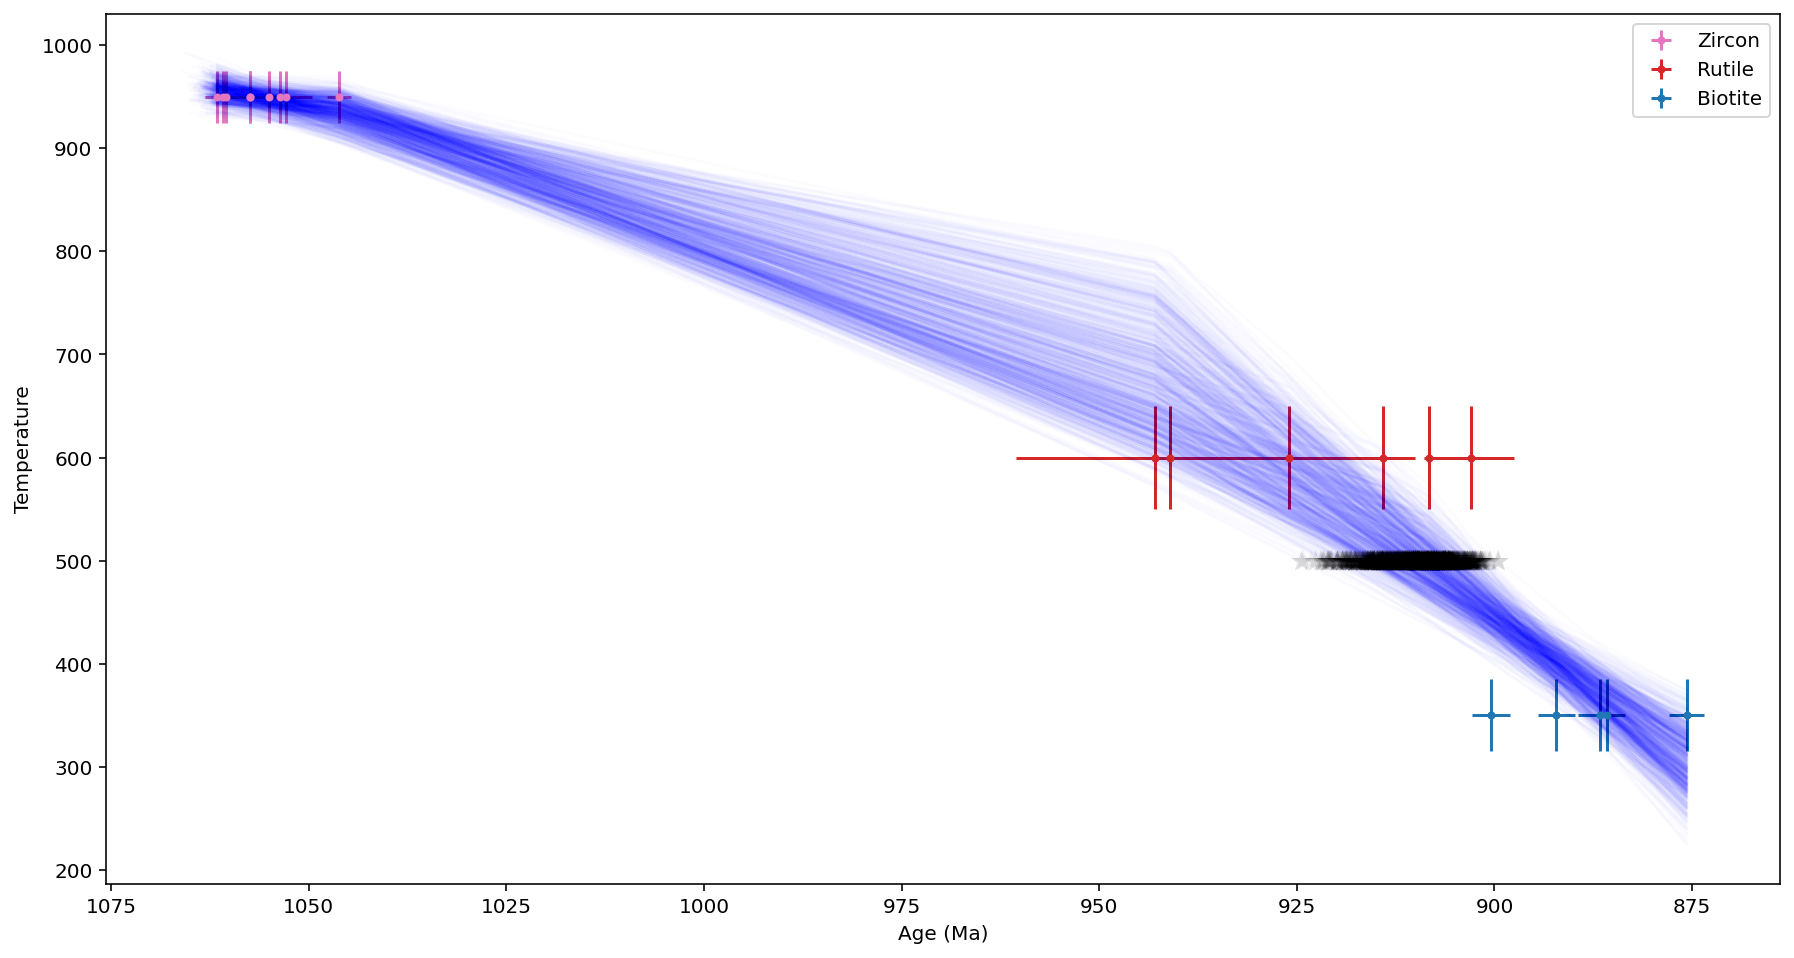

In [67]:
n_samples = 1000
plt.figure(figsize=(12, 8))
plt.figure(figsize=(15, 8))

for i in Allard_Urbain_ages.Age_Material.unique():
    this_material = Allard_Urbain_ages[Allard_Urbain_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)

    
for j in range(n_samples):
    this_row = Allard_Urbain_trace_df.sample(n=1)
    y=[]
    this_start_age = this_row['start_age'].values[0]
    this_start_temp = this_row['start_temp'].values[0]

    for i in range(len(Allard_Urbain_nominal_ages)):
        y.append(get_cooling_history_2(this_start_age, this_start_temp, 
                                  this_row['rate_1'].values[0], this_row['rate_2'].values[0], 
                                  this_row['changepoint_1'].values[0], this_row['changepoint_2'].values[0], 
                                             Allard_Urbain_nominal_ages[i]))
    plt.plot([this_start_age]+Allard_Urbain_nominal_ages, [this_start_temp]+y, color='b', alpha = 0.01)
    
plt.scatter(Allard_Urbain_age_at_500, np.full(len(Allard_Urbain_age_at_500), 500), marker = '*', lw=0.1, c='k', alpha=0.05, edgecolor='k', s=120, zorder = 100)

plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
plt.legend()
plt.savefig('../figure/Allard_Urbain_thermal_history.pdf')
plt.show()

## Adirondack Lowlands

In [53]:
Adirondack_lowlands_ages = pd.read_csv('../data/thermochron_compilation/Adirondack_lowlands_ages.csv')
Adirondack_lowlands_ages = Adirondack_lowlands_ages[~Adirondack_lowlands_ages['Sample_No'].str.contains('A102')]
Adirondack_lowlands_ages = Adirondack_lowlands_ages[~Adirondack_lowlands_ages['Age_Material'].str.contains('Rutile|K-Feldspar')]
Adirondack_lowlands_ages = Adirondack_lowlands_ages.sort_values(by='Age', ascending=0).reset_index(drop=1)
Adirondack_lowlands_ages['closure_temp'] = [closure_temp_bounds_dict[i][0] for i in Adirondack_lowlands_ages['Age_Material']]
Adirondack_lowlands_ages['closure_temp_sigma'] = [closure_temp_bounds_dict[i][1] for i in Adirondack_lowlands_ages['Age_Material']]

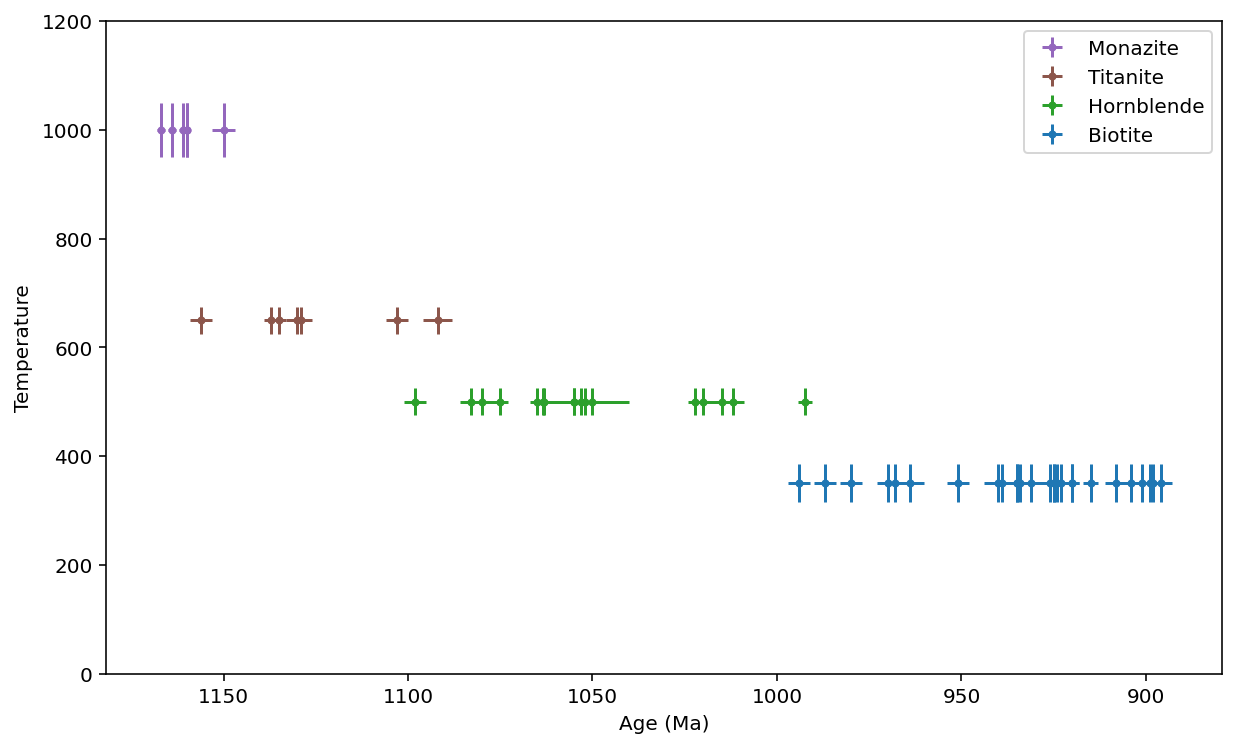

In [54]:
plt.figure(figsize=(10, 6))
for i in Adirondack_lowlands_ages.Age_Material.unique():
    closure_temp_bounds = closure_temp_bounds_dict[i]
    this_material = Adirondack_lowlands_ages[Adirondack_lowlands_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], np.full(len(this_material['Age']),closure_temp_bounds[0]), closure_temp_bounds[1], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)
plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
plt.ylim(0, 1200)
# plt.xlim(1100, 750)
plt.legend()
plt.show()

In [55]:
Adirondack_lowlands_nominal_ages = Adirondack_lowlands_ages['Age'].tolist()
Adirondack_lowlands_sigmas = list((Adirondack_lowlands_ages['Error_Minus']+Adirondack_lowlands_ages['Error_Plus']).to_numpy()/2)
Adirondack_lowlands_temps = Adirondack_lowlands_ages['closure_temp'] 
Adirondack_lowlands_temp_sigmas = Adirondack_lowlands_ages['closure_temp_sigma']

In [56]:
with pm.Model() as model:
    
    start_index = np.argmax(Adirondack_lowlands_nominal_ages)
    start_age = pm.Normal('start_age', max(Adirondack_lowlands_nominal_ages), Adirondack_lowlands_sigmas[start_index])
    start_temp = pm.Normal('start_temp', Adirondack_lowlands_temps[start_index], Adirondack_lowlands_temp_sigmas[start_index])
    
    rate_1 = pm.Uniform('rate_1', lower=0., upper=10)
    rate_2 = pm.Uniform('rate_2', lower=0., upper=10)
    rate_3 = pm.Uniform('rate_3', lower=0., upper=10)
    
    changepoint_1 = pm.Uniform('changepoint_1', lower=min(Adirondack_lowlands_nominal_ages), upper=max(Adirondack_lowlands_nominal_ages))
    changepoint_2 = pm.Uniform('changepoint_2', lower=min(Adirondack_lowlands_nominal_ages), upper=max(Adirondack_lowlands_nominal_ages))
    changepoint_3 = pm.Uniform('changepoint_3', lower=0., upper=.1)
    
    for i, (age, sigma, temp, temp_sigma) in enumerate(zip(Adirondack_lowlands_nominal_ages, Adirondack_lowlands_sigmas, 
                                                           Adirondack_lowlands_temps, Adirondack_lowlands_temp_sigmas)):
        print('measurement'+str(i), age, sigma, temp, temp_sigma)
        this_age = pm.Normal('age'+str(i), age, sigma)
        observed_temp = pm.Normal('measurement'+str(i), 
                                  cooling_history_3(start_age, start_temp, rate_1, rate_2, rate_3, 
                                                    changepoint_1, changepoint_2, changepoint_3, this_age), 
                                  np.array(temp_sigma),
                                  observed=temp)
    
#     Adirondack_lowlands_trace = pm.sample(2500, cores=1, chains=1, tune=1000)

measurement0 1167.0 1.0 1000 50.0
measurement1 1164.0 1.0 1000 50.0
measurement2 1161.0 1.0 1000 50.0
measurement3 1160.0 1.0 1000 50.0
measurement4 1160.0 1.0 1000 50.0
measurement5 1156.0 3.0 650 25.0
measurement6 1150.0 3.0 1000 50.0
measurement7 1137.0 2.0 650 25.0
measurement8 1135.0 2.0 650 25.0
measurement9 1130.0 3.0 650 25.0
measurement10 1129.0 3.0 650 25.0
measurement11 1103.0 3.0 650 25.0
measurement12 1098.0 3.0 500 25.0
measurement13 1092.0 4.0 650 25.0
measurement14 1083.0 3.0 500 25.0
measurement15 1080.0 3.0 500 25.0
measurement16 1075.01 2.1 500 25.0
measurement17 1065.08 1.93 500 25.0
measurement18 1063.43 1.34 500 25.0
measurement19 1063.0 3.0 500 25.0
measurement20 1055.0 3.0 500 25.0
measurement21 1055.0 10.0 500 25.0
measurement22 1053.0 4.0 500 25.0
measurement23 1051.97 1.39 500 25.0
measurement24 1050.0 10.0 500 25.0
measurement25 1022.11 1.29 500 25.0
measurement26 1020.0 4.0 500 25.0
measurement27 1015.0 3.0 500 25.0
measurement28 1012.0 3.0 500 25.0
measure

In [57]:
# pm.save_trace(Adirondack_lowlands_trace, 'code_output/Adirondack_lowlands_trace')

In [58]:
Adirondack_lowlands_trace_df = load_trace('./code_output/Adirondack_lowlands_trace/0/samples.npz')

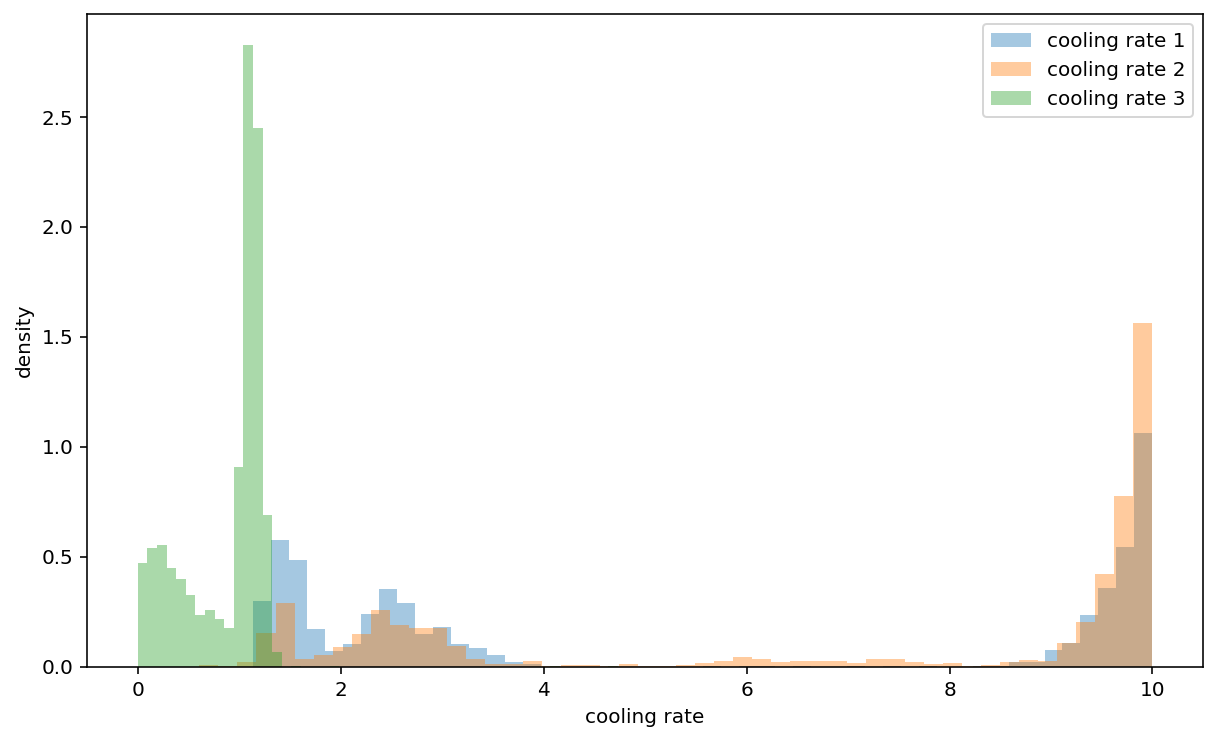

In [59]:
plt.figure(figsize=(10,6))
sns.distplot(Adirondack_lowlands_trace_df['rate_1'], bins=50, kde=0, norm_hist=1, label='cooling rate 1')
sns.distplot(Adirondack_lowlands_trace_df['rate_2'], bins=50, kde=0, norm_hist=1, label='cooling rate 2')
sns.distplot(Adirondack_lowlands_trace_df['rate_3'], bins=50, kde=0, norm_hist=1, label='cooling rate 3')
plt.xlabel('cooling rate')
plt.ylabel('density')
plt.legend()
plt.show()

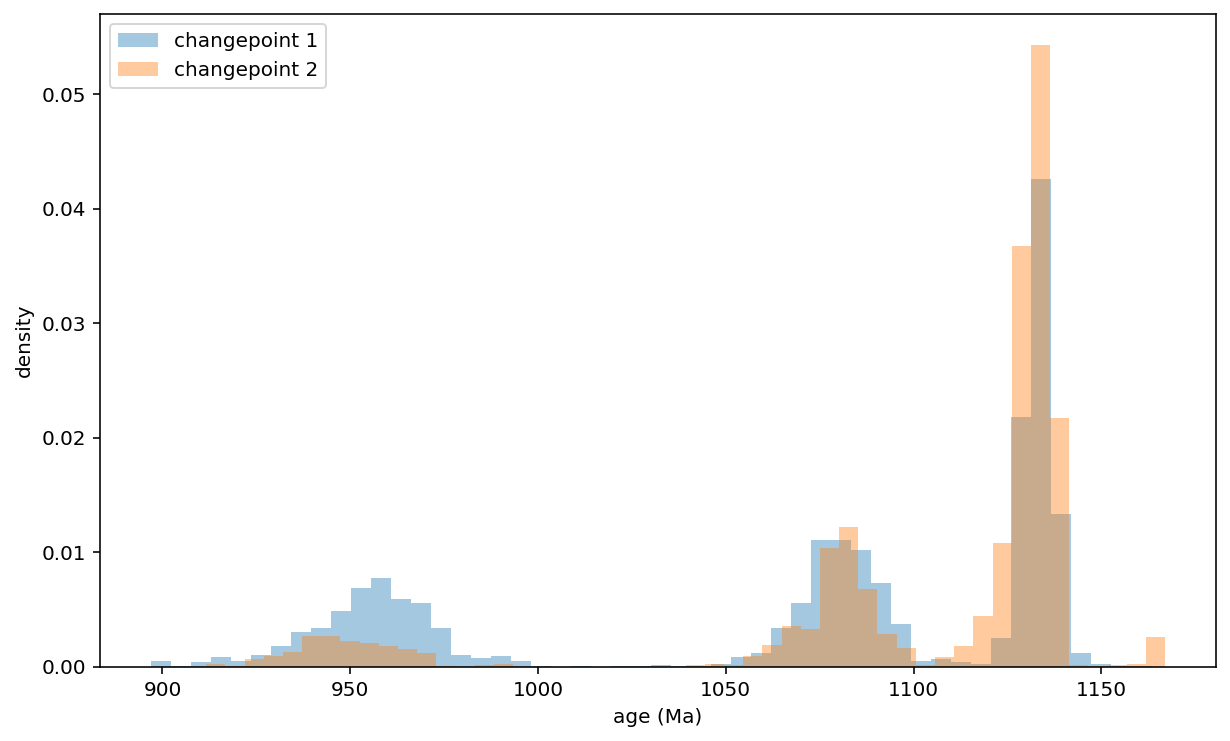

In [60]:
plt.figure(figsize=(10,6))
sns.distplot(Adirondack_lowlands_trace_df['changepoint_1'], bins=50, kde=0, norm_hist=1, label='changepoint 1')
sns.distplot(Adirondack_lowlands_trace_df['changepoint_2'], bins=50, kde=0, norm_hist=1, label='changepoint 2')
plt.xlabel('age (Ma)')
plt.ylabel('density')
plt.legend()
plt.show()

In [61]:
Adirondack_lowlands_age_at_500 = find_age_at_temp(Adirondack_lowlands_trace_df, Adirondack_lowlands_nominal_ages, 500, n_rates=3)

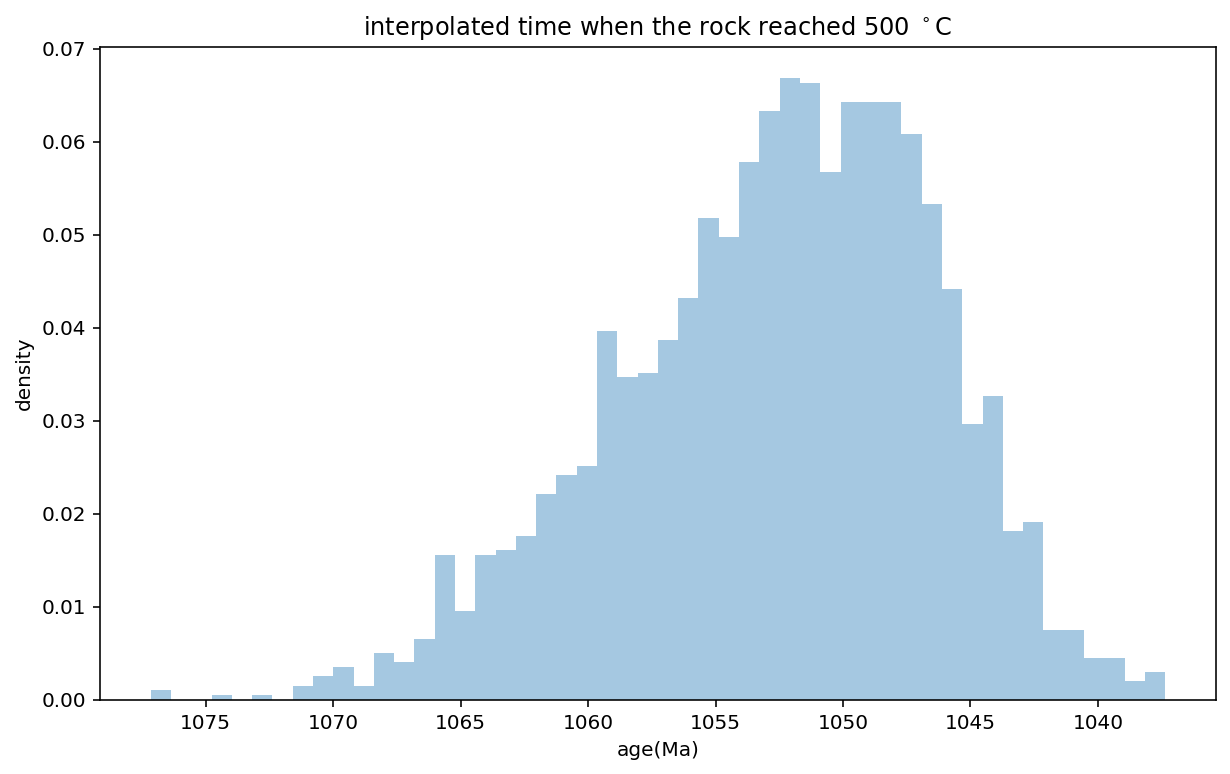

In [62]:
plt.figure(figsize=(10,6))
sns.distplot(Adirondack_lowlands_age_at_500, kde=0, bins=50, norm_hist=1)
plt.xlabel('age(Ma)')
plt.ylabel('density')
plt.title('interpolated time when the rock reached 500 $^\circ$C' )
plt.gca().invert_xaxis()
plt.show()

<Figure size 864x576 with 0 Axes>

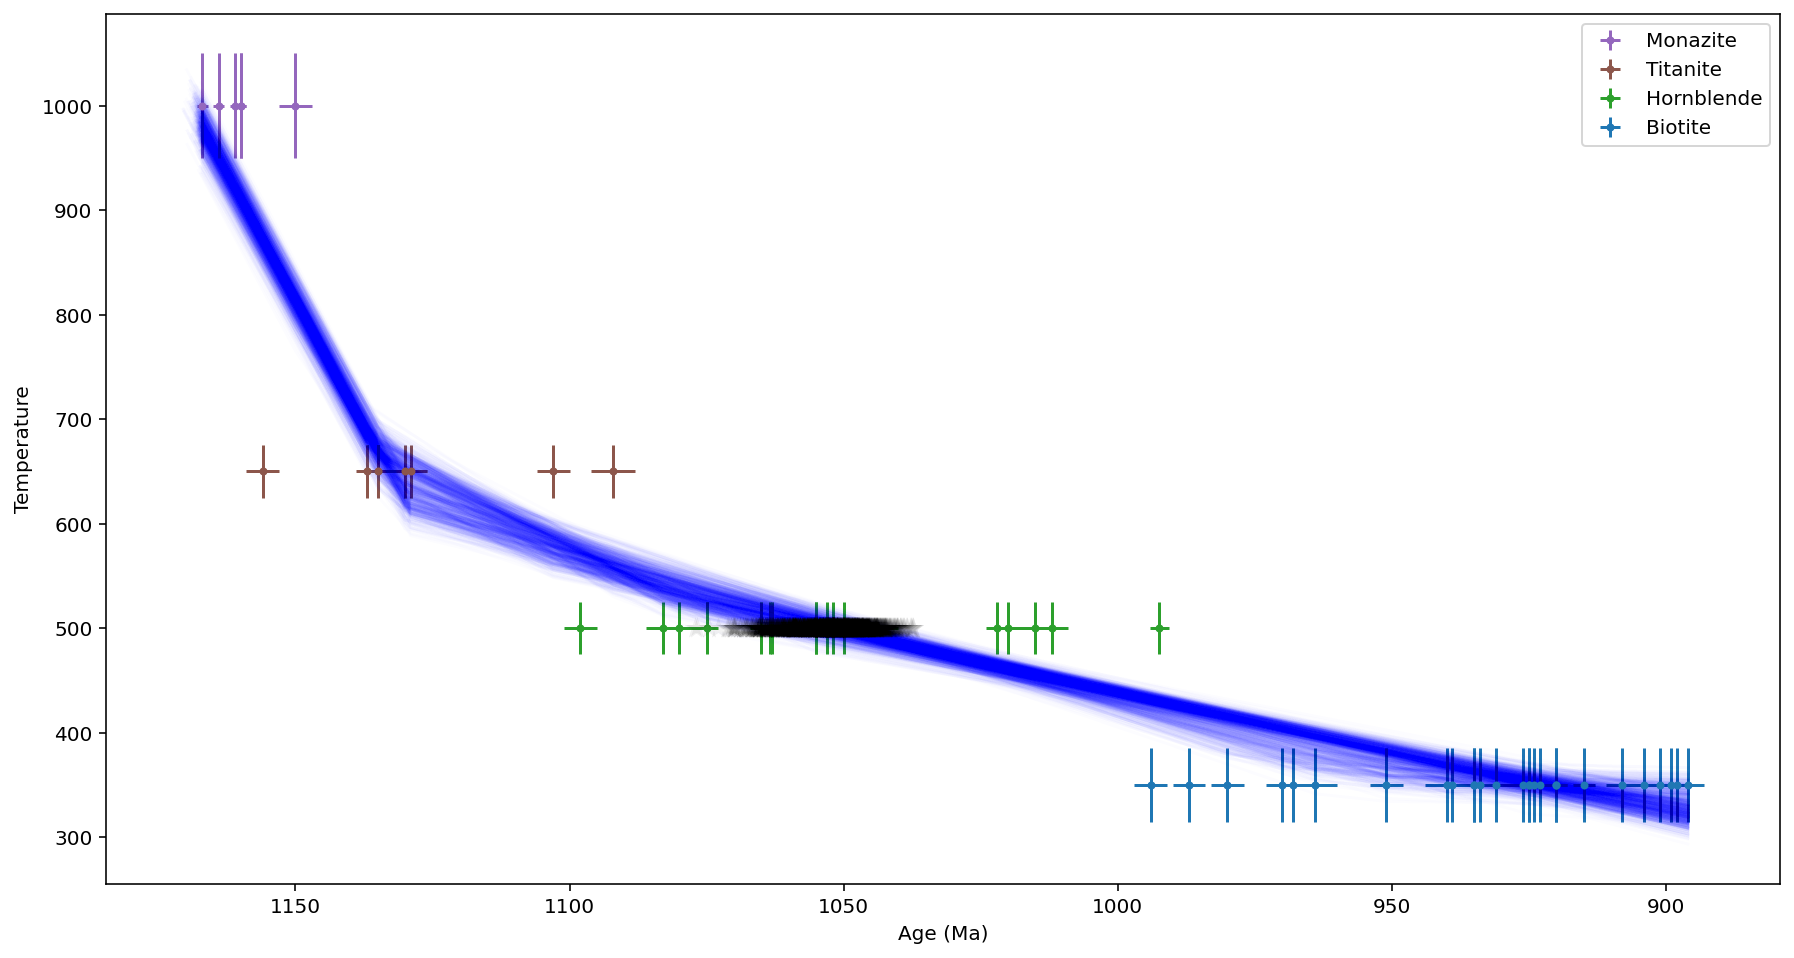

In [69]:
n_samples = 1000
plt.figure(figsize=(12, 8))
plt.figure(figsize=(15, 8))

for i in Adirondack_lowlands_ages.Age_Material.unique():
    this_material = Adirondack_lowlands_ages[Adirondack_lowlands_ages['Age_Material'] == i]
    plt.errorbar(this_material['Age'], this_material['closure_temp'], 
                 this_material['closure_temp_sigma'], this_material['Error_Plus'], fmt='.',
                 color=color_dict[i], ls='None', label=i)

    
for j in range(n_samples):
    this_row = Adirondack_lowlands_trace_df.sample(n=1)
    y=[]
    this_start_age = this_row['start_age'].values[0]
    this_start_temp = this_row['start_temp'].values[0]

    for i in range(len(Adirondack_lowlands_nominal_ages)):
        y.append(get_cooling_history_3(this_start_age, this_start_temp, 
                                  this_row['rate_1'].values[0], this_row['rate_2'].values[0], this_row['rate_3'].values[0], 
                                  this_row['changepoint_1'].values[0], this_row['changepoint_2'].values[0], this_row['changepoint_3'].values[0], 
                                             Adirondack_lowlands_nominal_ages[i]))
    plt.plot([this_start_age]+Adirondack_lowlands_nominal_ages, [this_start_temp]+y, color='b', alpha = 0.01)
    
plt.scatter(Adirondack_lowlands_age_at_500, np.full(len(Adirondack_lowlands_age_at_500), 500), 
            marker = '*', lw=0.1, c='k', alpha=0.05, edgecolor='k', s=120, zorder = 100)

plt.ylabel('Temperature')
plt.xlabel('Age (Ma)')
plt.gca().invert_xaxis()
plt.legend()
plt.savefig('../figure/Adirondack_lowlands_thermal_history.pdf')
plt.show()